<a href="https://colab.research.google.com/github/mdubouch/noise-gan/blob/master/noise_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import sys
!{sys.executable} -m pip install uproot

     |████████████████████████████████| 122kB 2.9MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 


In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm # colormaps
import matplotlib.colors as mcolors
import matplotlib.lines as lines
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = False
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['savefig.facecolor'] = 'white'

In [3]:
!wget http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/reconstructible_mc5a02_rconsthits.root
!wget http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/chanmap_20180416.root

--2020-10-16 07:15:11--  http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/reconstructible_mc5a02_rconsthits.root
Resolving www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)... 146.179.108.103, 2a0c:5bc0:88:111:216:3eff:fe7f:177
Connecting to www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)|146.179.108.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46081707 (44M)
Saving to: ‘reconstructible_mc5a02_rconsthits.root’

reconstructible_mc5 100%[===================>]  43.95M  22.5MB/s    in 2.0s    

2020-10-16 07:15:13 (22.5 MB/s) - ‘reconstructible_mc5a02_rconsthits.root’ saved [46081707/46081707]

--2020-10-16 07:15:13--  http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/chanmap_20180416.root
Resolving www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)... 146.179.108.103, 2a0c:5bc0:88:111:216:3eff:fe7f:177
Connecting to www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)|146.179.108.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1809231 (1.7M)
Saving to: ‘chanmap_20180416.root

In [4]:
file = uproot.open('reconstructible_mc5a02_rconsthits.root')
n_pot = 990678399
n_bunches = n_pot / 16e6
print(n_bunches)

61.9173999375


In [5]:
rconst = file['rconst_hit/rconst_hit'].array()

In [6]:
print(rconst.dtype, rconst.shape)

[('edep', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8'), ('doca', '<f8'), ('track_id', '<i4'), ('event_id', '<i4'), ('pid', '<i4'), ('wire', '<i4'), ('layer', '<i4')] (63648,)


In [7]:
data = file['noise/noise'].array()

In [8]:
print(data.dtype)
print(data.shape)

[('edep', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8'), ('doca', '<f8'), ('track_id', '<i4'), ('event_id', '<i4'), ('pid', '<i4'), ('wire', '<i4'), ('layer', '<i4')]
(634266,)


In [9]:
f_chanmap = uproot.open('chanmap_20180416.root')

In [10]:
chan_tree = f_chanmap['t']
chan_tree.keys()

[b'LayerLength',
 b'layer',
 b'wire',
 b'xhv',
 b'yhv',
 b'x0',
 b'y0',
 b'xro',
 b'yro',
 b'LayerID',
 b'isSenseWire',
 b'CellID',
 b'BoardID',
 b'BrdLayID',
 b'BrdLocID',
 b'ChanID']

In [11]:
xro = chan_tree['xro'].array()
yro = chan_tree['yro'].array()
map_layerid = chan_tree['LayerID'].array()
map_wire = chan_tree['wire'].array()

issense = chan_tree['isSenseWire'].array()

In [12]:
n_wires_per_layer = np.zeros(np.unique(map_layerid).size, dtype=int)
for l in np.unique(map_layerid):
    n_wires_per_layer[l] = map_wire[(map_layerid==l) * (issense==True)].size

In [13]:
n_wires_per_layer

array([198, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264,
       270, 276, 282, 288, 294, 300, 306])

In [14]:
cum_n_wires = np.concatenate([[0], np.cumsum(n_wires_per_layer)])
cum_n_wires

array([   0,  198,  396,  600,  810, 1026, 1248, 1476, 1710, 1950, 2196,
       2448, 2706, 2970, 3240, 3516, 3798, 4086, 4380, 4680, 4986])

In [15]:
def wire_abs_to_rel(wire_idx):
    layer = (wire_idx[:, np.newaxis] >= cum_n_wires).sum(axis=1) - 1
    wire = wire_idx - (cum_n_wires[layer])

    return (layer, wire)

In [16]:
# Validate wire IDs
assert(
    np.equal(wire_abs_to_rel(np.array([10, 198, 198+198, 198+198+204, 198+198+204-1])), 
             (np.array([0, 1, 2, 3, 2]), np.array([10, 0, 0, 0, 203]))).all()
)

In [17]:
# Define everything in terms of only sense wires

xro = chan_tree['xro'].array()
yro = chan_tree['yro'].array()
map_layerid = chan_tree['LayerID'].array()
map_wire = chan_tree['wire'].array()

issense = chan_tree['isSenseWire'].array()

xro = xro[issense==True]
yro = yro[issense==True]
map_layerid = map_layerid[issense==True]
map_wire = map_wire[issense==True]

In [18]:
def wire_rel_to_abs(layer_idx, wire_idx):
    return cum_n_wires[layer_idx] + wire_idx

map_wire_abs = wire_rel_to_abs(map_layerid, map_wire)
n_wires = np.unique(map_wire_abs).size
map_wire_abs[np.arange(0, n_wires)] = np.arange(0, n_wires)

def wire_pos(wire_abs_idx):
    cond = (wire_abs_idx[:, np.newaxis] == map_wire_abs)
    big_xro = np.tile(xro, (wire_abs_idx.size, 1))
    big_yro = np.tile(yro, (wire_abs_idx.size, 1))
    
    arr = (big_xro[cond], big_yro[cond])
    
    return arr

In [19]:
wire_x, wire_y = wire_pos(np.arange(0, map_wire_abs.size))

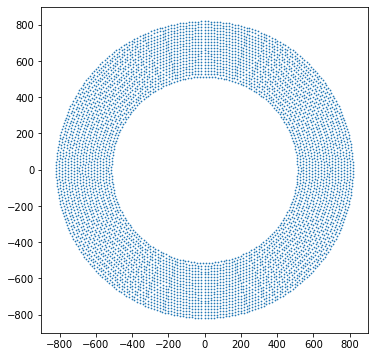

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(wire_x, wire_y, s=0.5)
plt.gca().set_aspect(1)

In [21]:
data

array([(1.65391964e-06, 7.17905639e+03, 5.56239699e+02, 8.05828593e+03, 9.27374282e+04,  4.13658225, 28936,     27873, 2212, 2538, 11),
       (2.91010000e-04, 7.17341393e+03, 6.50288519e+02, 7.54955677e+03, 1.59833529e+02,  8.1832893 , 23838,     76196,   22, 2005,  9),
       (1.14081820e-02, 7.17341393e+03, 6.50288519e+02, 7.54955677e+03, 1.59834777e+02,  8.02174592, 23871,     76196,   11, 2005,  9),
       ...,
       (4.22752599e-02, 7.15930777e+03, 1.16881757e+02, 7.08394112e+03, 2.38158953e+03,  6.59814942, 26925, 990648059, 2212,  817,  4),
       (6.41031571e-04, 7.20162625e+03, 2.55968593e+02, 8.42691961e+03, 2.08610276e+05,  1.28351185, 22383, 990661842,   11, 4817, 19),
       (6.78203753e-06, 1.00000000e+09, 1.00000000e+09, 1.00000000e+09, 2.08610381e+05, 10.278884  , 22383, 990661842,   11,   -1, -1)],
      dtype=[('edep', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8'), ('doca', '<f8'), ('track_id', '<i4'), ('event_id', '<i4'), ('pid', '<i4'), ('wire', '

In [22]:
data['edep'][data['edep']>1]

array([1.32142575, 1.13802944, 1.30253186, 1.08595184, 1.76836657,
       2.99576322, 3.25848603, 2.24333139, 1.40842168, 1.23769951,
       1.53135095, 1.17440209, 1.43822854, 1.02772669, 1.060447  ,
       1.99200724, 1.65378305, 1.22118523, 1.60574738, 1.01694917,
       1.52334084, 1.37580351, 1.36760617, 1.02669722, 1.10397545,
       1.02449066, 1.57215238, 1.54516597, 1.51112067, 1.19505052,
       2.22557461, 1.54055276, 1.09129702, 2.08608732, 1.34075573,
       1.16003295, 1.20340587, 1.02961549, 1.36952847, 1.28235272,
       1.42080384, 1.80494424, 1.08857244, 1.38279978, 1.25469144,
       1.52949868, 1.41814916, 1.67112684, 1.71858699, 1.34228618,
       1.0942428 , 1.22445918, 1.1546787 , 1.00454576, 1.23697416,
       1.32950507, 1.0126158 , 1.5008969 , 1.42695186, 1.29021037,
       1.31497036, 1.07056392, 1.3251631 , 1.04100422, 1.51175175,
       1.04176298, 1.22828446, 1.26309171, 1.06762421, 1.56453537,
       1.10389728, 1.03878775, 1.43034137, 1.02877482, 1.00163

In [23]:
# Set up the data, throw away the invalid ones
rconst_wire = rconst['wire']
rconst_event_id = rconst['event_id']
rconst_layer = rconst['layer']
rconst_edep = rconst['edep']
rconst_doca = rconst['doca']
rconst_t = rconst['t']
rconst_dbg_x = rconst['x']
rconst_dbg_y = rconst['y']
rconst_dbg_z = rconst['z']
rconst_track_id = rconst['track_id']
rconst_pid = rconst['pid']

_select = (rconst_wire>=0) * (rconst_edep>1e-6)
rconst_layer = rconst_layer[_select]
rconst_event_id = rconst_event_id[_select]
rconst_t = rconst_t[_select]
rconst_dbg_x = rconst_dbg_x[_select]
rconst_dbg_y = rconst_dbg_y[_select]
rconst_dbg_z = rconst_dbg_z[_select]
rconst_track_id = rconst_track_id[_select]
rconst_pid = rconst_pid[_select]
rconst_doca = rconst_doca[_select]
rconst_wire = rconst_wire[_select]

rconst_edep = rconst_edep[(rconst['wire']>=0) * (rconst_edep>1e-6)]

print(rconst_wire.size, rconst_pid.size, rconst_doca.size)

63590 63590 63590


In [24]:
# /!\ Careful memory hungry!
# Let's do it in steps
N_steps = 10
rconst_wx, rconst_wy = wire_pos(rconst_wire[:rconst.size // N_steps])

for i in range(1,N_steps):
    _wx, _wy = wire_pos(rconst_wire[i*rconst.size//N_steps:(i+1)*rconst.size//N_steps])
    rconst_wx = np.concatenate([rconst_wx, _wx])
    rconst_wy = np.concatenate([rconst_wy, _wy])

print(rconst_wx.size, rconst_wy.size, rconst_pid.size)

63590 63590 63590


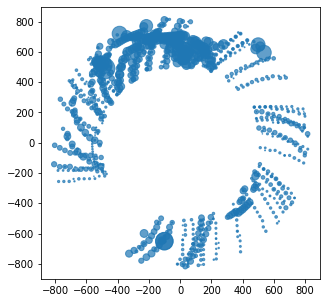

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(rconst_wx[:1000], rconst_wy[:1000], s=rconst_edep[:1000] * 1e3, alpha=0.7)

In [26]:
# Set up the data, throw away the invalid ones
wire = data['wire']
event_id = data['event_id']
layer = data['layer']
edep = data['edep']
doca = data['doca']
t = data['t']
dbg_x = data['x']
dbg_y = data['y']
dbg_z = data['z']
track_id = data['track_id']
pid = data['pid']

_select = (wire>=0) * (edep>1e-6)
layer = layer[_select]
event_id = event_id[_select]
t = t[_select]
dbg_x = dbg_x[_select]
dbg_y = dbg_y[_select]
dbg_z = dbg_z[_select]
track_id = track_id[_select]
pid = pid[_select]
doca = doca[_select]
wire = wire[_select]

edep = edep[(data['wire']>=0) * (edep>1e-6)]

print(wire.size, pid.size, doca.size)

628243 628243 628243


In [27]:
# /!\ Careful memory hungry!
# Let's do it in steps
N_steps = 10
wx, wy = wire_pos(wire[:data.size // N_steps])

for i in range(1,N_steps):
    _wx, _wy = wire_pos(wire[i*data.size//N_steps:(i+1)*data.size//N_steps])
    wx = np.concatenate([wx, _wx])
    wy = np.concatenate([wy, _wy])

print(wx.size, wy.size, pid.size)

628243 628243 628243


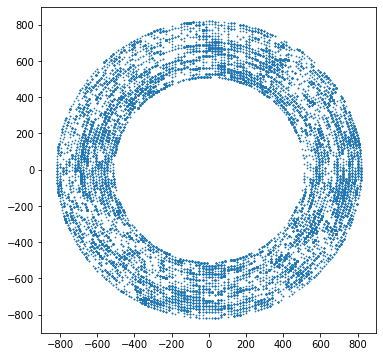

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(wx[:50000], wy[:50000], s=0.5);

Draw the wire grid

In [29]:
def grid_and_walls(ax):
    # Draw grid
    px, py = wire_pos(np.arange(0, map_wire_abs.size))
    ax.scatter(px, py, s=0.2, marker='.', edgecolors=None, c='gray', alpha=0.7)
    
    # Draw walls
    inner = Ellipse((0, 0), 488*2, 488*2, facecolor=(0, 0, 0, 0), edgecolor='gray')
    outer = Ellipse((0, 0), 846*2, 846*2, facecolor=(0, 0, 0, 0), edgecolor='gray')

    plt.gca().add_patch(inner)
    plt.gca().add_patch(outer);
    
    ax.set(xlim=(-900,900), ylim=(-900,900), xlabel='x [mm]', ylabel='y [mm]')
    
    
def only_walls(ax):
    # Draw walls
    inner = Ellipse((0, 0), 488*2, 488*2, facecolor=(0, 0, 0, 0), edgecolor='gray')
    outer = Ellipse((0, 0), 846*2, 846*2, facecolor=(0, 0, 0, 0), edgecolor='gray')

    plt.gca().add_patch(inner)
    plt.gca().add_patch(outer);
    
    ax.set(xlim=(-900,900), ylim=(-900,900), xlabel='x [mm]', ylabel='y [mm]')

# Setup pytorch

628243


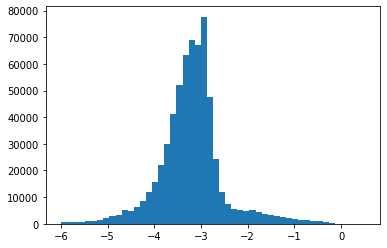

In [30]:
plt.hist(np.log10(edep), bins=50)
print(edep.size)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

In [32]:
print(torch.cuda.is_available())
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

True
Tesla P100-PCIE-16GB


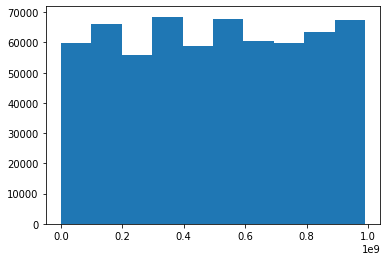

In [33]:
plt.hist(event_id);

In [34]:
wire.shape, wx.shape

((628243,), (628243,))

In [35]:
def define_sequences(seq_len):
    train = rconst_wire
    #train = (train - train.min(axis=1, keepdims=True)) / (train.max(axis=1, keepdims=True) - train.min(axis=1, keepdims=True)) * 2 - 1

    train = torch.from_numpy(train).unsqueeze(0).long()
    print(train.shape, train.dtype)
    stride = 1
    unfolded = train.unfold(1, seq_len, stride).permute(2, 1, 0)
    print(unfolded.shape)

    train_test_split = unfolded.shape[1] // 10

    train_x = unfolded[:-1,:,:][:,train_test_split:]
    train_y = unfolded[-1:,:,:][:,train_test_split:]

    test_x = unfolded[:-1,:,:][:,:train_test_split]
    test_y = unfolded[-1:,:,:] [:,:train_test_split]
    print(train_x.shape, train_y.shape)
    print(test_x.shape, test_y.shape)
    return to_device(train_x), to_device(train_y), to_device(test_x), to_device(test_y)

_train_x, _train_y, _test_x, _test_y = define_sequences(seq_len=4)

torch.Size([1, 63590]) torch.int64
torch.Size([4, 63587, 1])
torch.Size([3, 57229, 1]) torch.Size([1, 57229, 1])
torch.Size([3, 6358, 1]) torch.Size([1, 6358, 1])


In [529]:
def define_context(window_size):
    train = wire
    #train = torch.from_numpy(train).unsqueeze(0).long()
    words = []
    context = []
    for i in range(train[window_size:-window_size].size):
        words.append(train[i+window_size])
        context.append([])
        for j in range(window_size):
            context[i].append(train[i + j])
        for j in range(window_size):
            context[i].append(train[i + j + window_size + 1])
        #print(words[-1])
        #print(context[-1])
        #print(train[i:i+window_size*2+1])
    words = np.array(words, dtype=np.int64)
    context = np.array(context, dtype=np.int64)

    test_size = words.size // 10

    return (to_device(torch.from_numpy(words[test_size:])), to_device(torch.from_numpy(context[test_size:])), 
            to_device(torch.from_numpy(words[:test_size])), to_device(torch.from_numpy(context[:test_size])))

context_size = 2
words, context, words_test, context_test = define_context(context_size // 2)
print(words.shape, context.shape, words_test.shape, context_test.shape)

torch.Size([565417]) torch.Size([565417, 2]) torch.Size([62824]) torch.Size([62824, 2])


In [530]:
class LSTMModel(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.embed_dims = 11
        self.seq_len = seq_len
        self.embed = nn.Embedding(num_embeddings=cum_n_wires[-1], embedding_dim=self.embed_dims)
        # Replace with LSTM
        self.lstm = nn.LSTM(self.embed_dims, hidden_size=8, num_layers=1)
        self.lin1 = nn.Linear(8 * seq_len, cum_n_wires[-1])
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        y = self.embed(x).squeeze()
        #y = self.lin1(y.permute(1, 0, 2).flatten(1,2))
        #y = self.lin2(self.act(y))
        y, state = self.lstm(y)
        #print(y.shape)
        y = self.lin1(y.permute(1, 0, 2).flatten(1,2))
        #print(y.shape)
        y = self.softmax(y)
        return y.squeeze()

class LinearModel(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.embed_dims = 5
        self.seq_len = seq_len
        self.embed = nn.Embedding(num_embeddings=cum_n_wires[-1], embedding_dim=self.embed_dims, scale_grad_by_freq=True, max_norm=4.0)
        self.embed.weight.data.uniform_(-1,1)
        self.act = nn.ReLU()
        self.lin1 = nn.Linear(_train_x.shape[0] * self.embed_dims, cum_n_wires[-1], bias=False)
        
    def forward(self, x):
        y = self.embed(x).squeeze(2)
        y = self.lin1(y.permute(1, 0, 2).flatten(1,2))
        #y = self.lin2(self.act(y))
        #y = self.softmax(y)
        return y#.squeeze()

class CBOWModel(nn.Module):
    def __init__(self, context_size):
        super().__init__()
        self.embed_dims = 13
        self.seq_len = context_size
        self.embed = nn.Embedding(num_embeddings=cum_n_wires[-1], embedding_dim=self.embed_dims, scale_grad_by_freq=False)#, max_norm=3.0)
        self.lin1 = nn.Linear(1 * self.embed_dims, cum_n_wires[-1], bias=True)
        
    def forward(self, x):
        y = self.embed(x)
        y = self.lin1(y.mean(dim=1))
        #y = self.lin2(self.act(y))
        #y = self.lin2(self.act(y))
        #y = self.softmax(y)
        return y#.squeeze()

def define_model(*args):
    model = CBOWModel(*args)
    return to_device(model)

model = define_model(context_size)

In [531]:
prev_weights = model.embed.weight.data.T.detach().clone().cpu().numpy()

In [532]:
# Reset loss history and optimizer
losses = []
acc = []
embed_grad_rms = []
test_losses = []
loss_fn = nn.CrossEntropyLoss(reduction='mean')
lr = 0.001 # learning rate
opt = torch.optim.Adam(model.parameters(), lr=lr)#, betas=(0.5, 0.999))
#opt = torch.optim.SGD(model.parameters(), lr)
n_epochs = 0

-----------------------------------------------------------------------------------------
epoch: 1499  progress: 1.000000  train loss: 2.247637  train acc: 0.390166


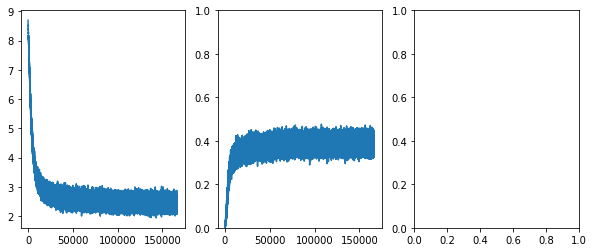

In [533]:
from IPython.display import clear_output

def do_training(model, epochs):
    model.train()
    global n_epochs

    for i in range(epochs):
        batch_size = 512
        for j in range(_train_x.shape[1] // batch_size):
            rand = torch.randint(0, context.shape[0] - batch_size, (batch_size,))
            #train = _train_x[:,j*batch_size:(j+1)*batch_size]
            #tgt = _train_y[:,j*batch_size:(j+1)*batch_size].squeeze()
            train = context[rand]
            tgt = words[rand]

            opt.zero_grad()

            #print('train', train.shape)
            pred = model(train)

            #print('pred', pred.shape)
            #print('tgt', tgt.shape)
            #return

            #tgt_embed = model.embed(tgt).detach().squeeze(2)

            #print(pred.shape, tgt.shape)
            loss = loss_fn(pred, tgt)


            choice = torch.argmax(pred, dim=1)
            acc.append((choice == tgt).sum().float().item() / batch_size)

            #print(loss)
            #print(loss)

            loss.backward()


            #print(model.embed.weight.grad.mean())
            opt.step()

            
            ##print(loss.shape, loss)
            losses.append(loss.item())

            #if ((j+1) % batch_size == 0):

        #embed_grad_rms.append((model.embed.weight.grad.data ** 2).mean())

        clear_output(wait=True)
        print('-' * 89)
        print("epoch: %d  progress: %f  train loss: %f  train acc: %f" % (n_epochs, (j+1) / (_train_x.shape[1] // batch_size), losses[-1], np.mean(acc[-1000:])))

        plt.figure(figsize=(10, 4))
        plt.subplot(131)
        plt.plot(losses)
        #plt.yscale('log')
        plt.subplot(132)
        plt.plot(acc)
        #plt.scatter(train[:,0,3].detach().cpu(), train[:,0,4].detach().cpu(), s=0.5)
        #plt.scatter(out[:,0,3].detach().cpu(), out[:,0,4].detach().cpu(), s=3)
        #plt.scatter(tgt[:,0,3].detach().cpu(), tgt[:,0,4].detach().cpu(), s=1)
        plt.ylim(0, 1)
        plt.subplot(133)
        #plt.plot(embed_grad_rms)
        plt.show()
        n_epochs += 1
    return model

_trained = do_training(model, 1500)

In [534]:
def do_testing(model):
    model.eval()

    batch_size = 256
    its = words_test.shape[0] // batch_size
    losses = []
    acc = []
    for i in range(its):
        indices = i*batch_size + torch.randperm(batch_size)
        test = context_test[indices]
        tgt = words_test[indices]

        pred = model(test)
        
        loss = loss_fn(pred, tgt)

        choice = torch.argmax(pred, dim=1)
        acc.append((choice == tgt).sum().float().item() / batch_size)

        losses.append(loss.item())


    test_losses.append(np.mean(losses))

    print('test loss:', test_losses)
    print('accuracy:', np.mean(acc))
    
do_testing(model)

test loss: [4.5107121778994195]
accuracy: 0.19162946428571428


Old: 

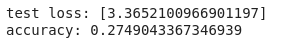

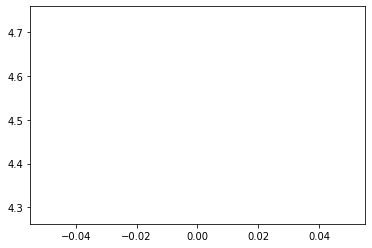

In [535]:
plt.plot(test_losses)

In [536]:
cum_n_wires

array([   0,  198,  396,  600,  810, 1026, 1248, 1476, 1710, 1950, 2196,
       2448, 2706, 2970, 3240, 3516, 3798, 4086, 4380, 4680, 4986])

avg dist: 11.174471855163574
min dist: 0.0009765625
max dist: 22.81283950805664


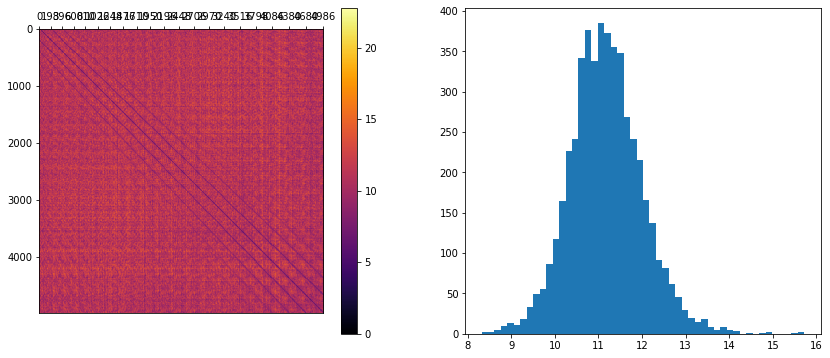

In [537]:
def avg_dist():
    weight_mat = model.embed.weight.data.detach()
    #print(weight_mat.shape)
    dist = torch.cdist(weight_mat, weight_mat).cpu()
    #print(dist.shape)
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.imshow(dist.cpu(), cmap='inferno')
    plt.colorbar()
    print('avg dist:', dist.mean().item())
    print('min dist:', dist[dist > 0.0].min().item())
    print('max dist:', dist.max().item())
    plt.xticks(cum_n_wires)
    plt.gca().xaxis.tick_top()
    plt.subplot(122)
    plt.hist(dist.mean(axis=0), bins=50)
    #print(dist[dist>0.0].shape)
avg_dist()

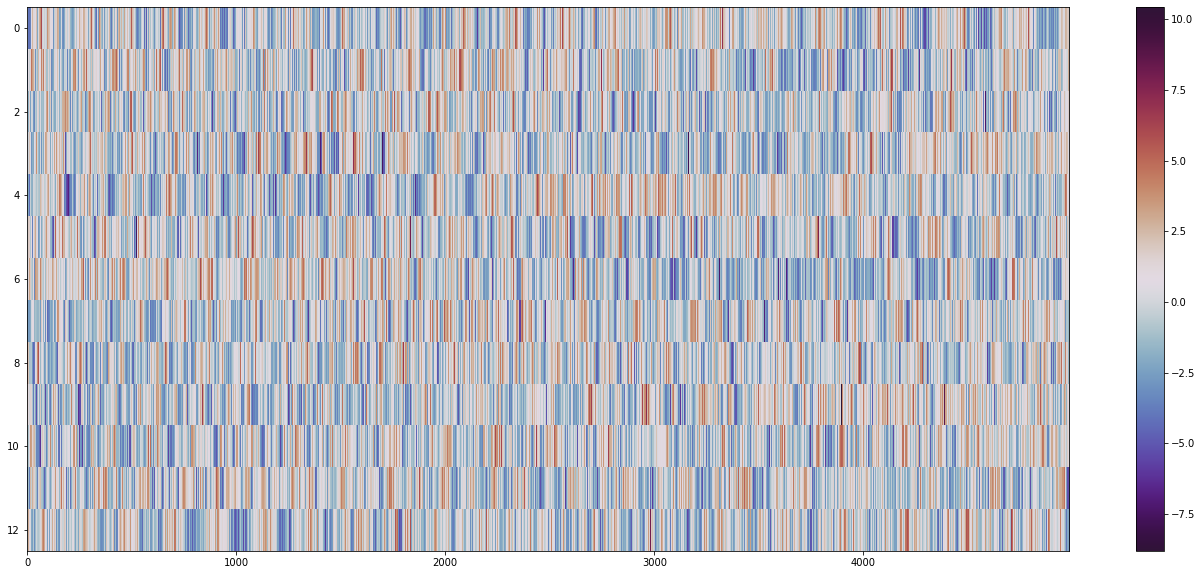

In [538]:
plt.figure(figsize=(24, 10))
plt.imshow(model.embed.weight.data.T.detach().cpu(), aspect=200, interpolation='none', cmap='twilight_shifted')
plt.colorbar()

In [539]:
model.embed.weight.data.shape

torch.Size([4986, 13])

Text(0.5, 1.0, 'Norm of embedding vectors')

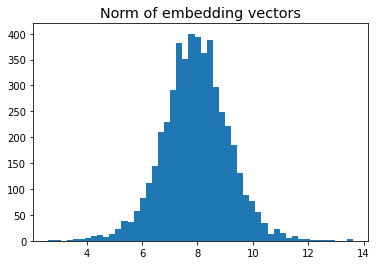

In [540]:
plt.hist(torch.norm(model.embed.weight.data, dim=1).detach().cpu(), bins=50);
plt.title('Norm of embedding vectors')

In [541]:
torch.sqrt(((model.embed.weight.data.T.detach().cpu() - prev_weights)**2).mean())

tensor(2.2095)

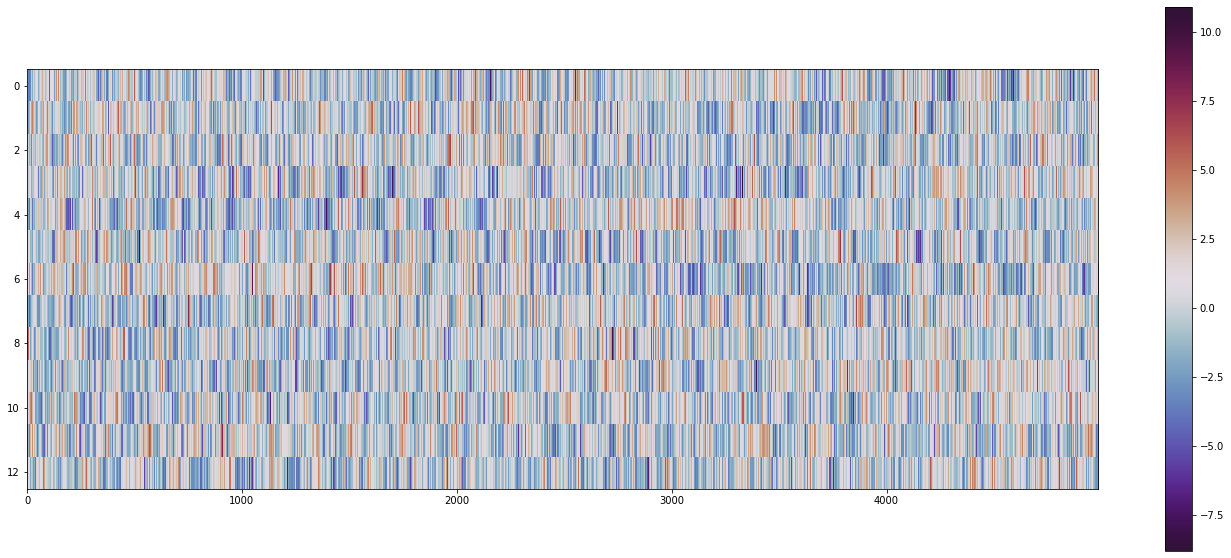

In [542]:
plt.figure(figsize=(24, 10))
plt.imshow(model.embed.weight.data.T.detach().cpu() - prev_weights, aspect=150, interpolation='none', cmap='twilight_shifted')
plt.colorbar()

In [543]:
prev_weights = model.embed.weight.data.T.detach().cpu().numpy()

In [544]:
n_epochs

1500

In [935]:
from google.colab import drive
import os
if os.path.exists('/content/drive') == False:
    drive.mount('/content/drive')

def save_states(version, epoch, path):
    states = { 'model': model.state_dict(), 'opt': opt.state_dict(), 'loss_hist': losses }
    torch.save(states, path + '/embed_states_%s_%de.pt' % (version, epoch))
    print('saved to ' + path + '/embed_states_%s_%de.pt' % (version, epoch))
def load_states(path):
    global losses
    global n_epochs
    states = torch.load(path) if torch.cuda.is_available() else torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(states['model'])
    opt.load_state_dict(states['opt'])
    losses = states['loss_hist']
    n_epochs = len(losses)
    print('done')

#save_states('8b49f58_13d_norm0', n_epochs, '/content/drive/My Drive/gan_states')
#load_states('/content/drive/My Drive/gan_states/embed_states_f4c76c4_13d_norm0_3040e.pt')

saved to /content/drive/My Drive/gan_states/embed_states_8b49f58_13d_norm0_100e.pt


In [547]:
embedded_wire = model.cpu().embed(torch.from_numpy(wire).long())

In [548]:
embedded_wire.shape

torch.Size([628243, 13])

In [549]:
train = np.array([np.log10(edep), np.log10(t), doca], dtype=np.float32)#, wire, layer], dtype=np.float32)

In [550]:
hit_group_size = 2048

In [551]:
_train = torch.from_numpy(train)
_train.shape

torch.Size([3, 628243])

In [552]:
_train = to_device(torch.cat([_train, embedded_wire.detach().T], dim=0))

In [553]:
def minmax_scale(tensor):
    print(tensor.shape)
    min = tensor.min(dim=1, keepdim=True).values
    print(min)
    max = tensor.max(dim=1, keepdim=True).values
    print(max)
    ret = (tensor - min) / (max - min) * 2 - 1.
    print(ret.min(), ret.max())

    return ret, min, max

def minmax_descale(tensor, min, max):
    return (tensor + 1.) / 2. * (max - min) + min

_train_minmax, train_min, train_max = minmax_scale(_train)

torch.Size([16, 628243])
tensor([[-5.9995],
        [ 1.6214],
        [ 0.0000],
        [-7.1464],
        [-7.5054],
        [-7.2706],
        [-8.6714],
        [-7.9757],
        [-8.8062],
        [-7.7110],
        [-6.9449],
        [-7.0710],
        [-7.6670],
        [-7.8082],
        [-7.1837],
        [-7.1954]], device='cuda:0')
tensor([[ 0.5130],
        [ 7.3559],
        [11.8383],
        [ 7.7610],
        [ 7.3664],
        [ 6.7754],
        [ 7.1436],
        [ 7.9052],
        [ 8.0882],
        [ 9.9537],
        [ 7.5926],
        [ 6.8314],
        [10.4263],
        [ 7.7494],
        [ 8.0199],
        [ 8.0573]], device='cuda:0')
tensor(-1., device='cuda:0') tensor(1., device='cuda:0')


In [554]:
___train = minmax_descale(_train_minmax, train_min, train_max)

In [926]:
hit_group_stride = 4

In [927]:
_train_unfold = _train_minmax.unfold(1, hit_group_size, hit_group_stride)

In [928]:
_train_unfold.shape

torch.Size([16, 156549, 2048])

In [929]:
#chunked = train.unfold(0, hit_group_size, 2).permute(1, 2, 0)
chunked = to_device(_train_unfold.permute(0, 2, 1))

In [930]:
chunked.shape

torch.Size([16, 2048, 156549])

In [931]:
print(chunked.shape, chunked.device)

torch.Size([16, 2048, 156549]) cuda:0


In [932]:
_inv = minmax_descale(chunked[:,0,:], train_min, train_max)

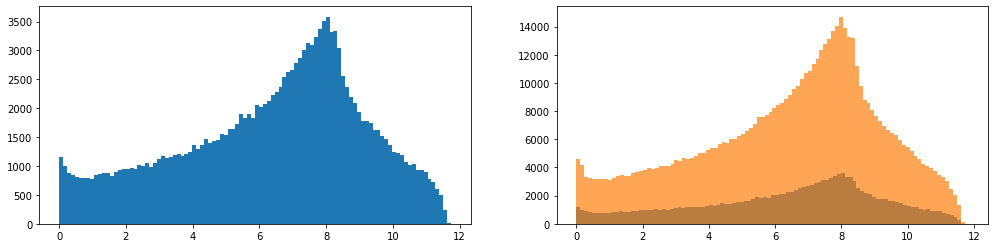

In [933]:
plt.figure(figsize=(17,4))
rainbow = cm.get_cmap('bone')
plt.subplot(121)
plt.hist(_inv[2].cpu(), bins=100);
#plt.scatter(_inv[0], _inv[3], s=0.1, alpha=0.2)#c=rainbow(np.arange(0, _inv[0].size) / _inv[0].size), alpha=0.8)
plt.subplot(122)
#plt.scatter(wx[:], wy[:], s=0.1, alpha=0.2)
plt.hist(_inv[2].cpu(), bins=100);
plt.hist(doca, bins=100, alpha=0.7);

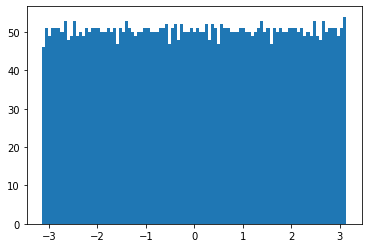

In [934]:
plt.hist(np.arctan2(wire_y, wire_x), bins=99);

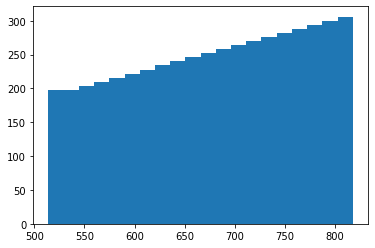

In [564]:
plt.hist(np.sqrt(wire_x**2 + wire_y**2), bins=20);

So the angular wire distribution is definitely flat in large-enough bins (99 is good number). The radial distribution is monotonically increasing with R, but does not have other features.

---

In [565]:
train.shape, chunked.shape

((3, 628243), torch.Size([16, 2048, 9785]))

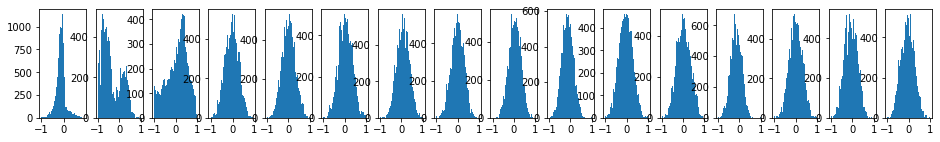

In [566]:
plt.figure(figsize=(16,2))
for i in range(chunked.shape[0]):
    plt.subplot(1, chunked.shape[0], i+1)
    plt.hist(chunked[i,0].flatten().cpu().detach().numpy(), bins=50);

In [841]:
n_features = chunked.shape[0]
seq_len = hit_group_size
input_dims = n_features * seq_len

bn_momentum = 0.1

ndf = 64
ngf = 32

latent_dims = 16*8

class Gen256Ups(nn.Module):
    def __init__(self):
        super().__init__()
        
        k = ngf
        self.k = k
        
        # Input: (B, latent_dims, 1)
        self.act = nn.LeakyReLU(0.2, True)

        self.lin0_1 = nn.Linear(latent_dims, 512)

        self.lin0_2 = nn.Linear(512, 512)

        self.lin0 = nn.Linear(512, n_features // 4 * seq_len)
        
        #self.lins6 = nn.Linear(seq_len // 64, seq_len // 16)
        self.linf6 = nn.Linear(n_features // 4, n_features // 2)
        self.bn6 = nn.InstanceNorm1d(n_features // 2)
        

        self.linf7 = nn.Linear(n_features // 2, n_features)
        #self.lins7 = nn.Linear(seq_len // 16, seq_len // 8)
        self.bn7 = nn.InstanceNorm1d(n_features)

        self.linf8 = nn.Linear(n_features, n_features*2)
        # #self.lins8 = nn.Linear(seq_len // 8, seq_len)
        self.bn8 = nn.InstanceNorm1d(n_features*2)

        self.linf11 = nn.Linear(n_features*2, n_features)

        self.out = nn.Tanh()
        
    def forward(self, z):
        # z: random point in latent space
        # stage: length of sequence returned by generator
        # alpha: blending factor (0 = upsampled image from previous layer; 1 = full image from new layer)
        
        x = self.act(self.lin0_1(z)) # (B, C*8 * L/64)

        x = self.act(self.lin0_2(x))

        x = self.act(self.lin0(x))

        x = x.view(-1, seq_len, n_features // 4)

        #x = self.bn6(self.act(self.linf6(self.act(self.lins6(x)).permute(0,2,1))).permute(0,2,1)).permute(0,2,1)
        #x = self.bn7(self.act(self.lins7(self.act(self.linf7(x)).permute(0,2,1)))).permute(0,2,1)
        #x = self.bn8(self.act(self.lins8(self.act(self.linf8(x)).permute(0,2,1)))).permute(0,2,1)
        x = self.bn6(self.act(self.linf6(x)).permute(0,2,1)).permute(0,2,1)
        x = self.bn7(self.act(self.linf7(x)).permute(0,2,1)).permute(0,2,1)
        x = self.bn8(self.act(self.linf8(x)).permute(0,2,1)).permute(0,2,1)

        x = self.linf11(x)

        return self.out(x.permute(0,2,1))

class Disc256Ups(nn.Module):
    def __init__(self):
        super().__init__()
        
        k = ndf
        self.k = k

        
        # (B, n_features, 256)
        self.act = nn.LeakyReLU(0.2, True)

        self.linf1 = nn.Linear(n_features, n_features * 8)

        self.linf2 = nn.utils.spectral_norm(nn.Linear(n_features * 8, n_features*4))
        # #self.lins2 = nn.Linear(seq_len, seq_len // 8)
        self.bn2 = nn.InstanceNorm1d(n_features*4)

        self.linf3 = nn.utils.spectral_norm(nn.Linear(n_features*4, n_features*2))
        self.bn3 = nn.InstanceNorm1d(n_features*2)

        self.linf4 = nn.utils.spectral_norm(nn.Linear(n_features*2, n_features*1))
        self.bn4 = nn.InstanceNorm1d(n_features*1)

        self.lin0 = nn.utils.spectral_norm(nn.Linear(seq_len * n_features*1, 512))

        self.lin0_1 = nn.utils.spectral_norm(nn.Linear(512, 128))

        self.lin0_2 = nn.utils.spectral_norm(nn.Linear(128, 1))

        self.out = nn.Identity()

    
    def forward(self, x_): # x shape is (batch, features, seq_len)
        x = x_
        
        x = self.act(self.linf1(x.permute(0, 2, 1)))
        #x = self.bn2(self.act(self.lins2(self.act(self.linf2(x)).permute(0,2,1))))
        x = self.bn2(self.act(self.linf2(x)).permute(0,2,1)).permute(0,2,1)
        
        x = self.bn3(self.act(self.linf3(x)).permute(0,2,1)).permute(0,2,1)

        x = self.bn4(self.act(self.linf4(x)).permute(0,2,1))

        x = x.view(-1, seq_len * n_features*1)

        x = self.act(self.lin0(x))
    
        x = self.act(self.lin0_1(x))

        x = self.lin0_2(x)

        return self.out(x.squeeze())

            
        
gen = to_device(Gen256Ups())
disc = to_device(Disc256Ups())
gen.train()
disc.train();

In [842]:
disc

Disc256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (linf1): Linear(in_features=16, out_features=128, bias=True)
  (linf2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (linf3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (linf4): Linear(in_features=32, out_features=16, bias=True)
  (bn4): InstanceNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (lin0): Linear(in_features=32768, out_features=512, bias=True)
  (lin0_1): Linear(in_features=512, out_features=128, bias=True)
  (lin0_2): Linear(in_features=128, out_features=1, bias=True)
  (out): Identity()
)

In [843]:
gen

Gen256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (lin0_1): Linear(in_features=128, out_features=512, bias=True)
  (lin0_2): Linear(in_features=512, out_features=512, bias=True)
  (lin0): Linear(in_features=512, out_features=8192, bias=True)
  (linf6): Linear(in_features=4, out_features=8, bias=True)
  (bn6): InstanceNorm1d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (linf7): Linear(in_features=8, out_features=16, bias=True)
  (bn7): InstanceNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (linf8): Linear(in_features=16, out_features=32, bias=True)
  (bn8): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (linf11): Linear(in_features=32, out_features=16, bias=True)
  (out): Tanh()
)

In [844]:
def get_n_params(model):
    return sum(p.reshape(-1).shape[0] for p in model.parameters())

print('generator params:', get_n_params(gen))
print('discriminator params:', get_n_params(disc))

generator params: 4532456
discriminator params: 16856561


In [845]:
# Sample `batch_size` vectors from the real distribution
def sample_real(batch_size, noise_strength=0.0):
    ids = np.random.choice(chunked.shape[2], size=batch_size)
    smpl = chunked[:,:,ids].permute(2, 0, 1)

    #smpl = nn.functional.avg_pool1d(smpl, kernel_size=256//stage)
    
    #_noise = noise_strength * torch.randn_like(smpl)
    return smpl# + _noise
    #return torch.clamp(smpl + _noise, -1, 1)#periodic(smpl + _noise, [2, 3, 4])

def def_modes(n_modes, sigma):
    means = torch.rand((n_modes,))#np.random.uniform(-1, 1, size=(n_modes))
    sigmas = sigma * torch.ones_like(means)
    return means, sigmas
means, sigmas = def_modes(16, 0.5)

def sample_fake(batch_size):
    mode = torch.randint(0, means.shape[0], (batch_size,))
    noise = to_device(means[mode] + torch.randn((batch_size, latent_dims)).T * sigmas[mode]).T
    _fk = gen(noise)
    return _fk

In [846]:
batch_size=64

In [847]:
discriminator_losses = []
generator_losses = []

In [848]:
sample_real(32).shape

torch.Size([32, 16, 2048])

In [849]:
sample_fake(32).shape

torch.Size([32, 16, 2048])

In [850]:
disc(sample_real(64)).shape

torch.Size([64])

In [851]:
print(gen)
print(disc)
print(disc(sample_real(64)).shape)
print(disc(sample_fake(64)).shape)

Gen256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (lin0_1): Linear(in_features=128, out_features=512, bias=True)
  (lin0_2): Linear(in_features=512, out_features=512, bias=True)
  (lin0): Linear(in_features=512, out_features=8192, bias=True)
  (linf6): Linear(in_features=4, out_features=8, bias=True)
  (bn6): InstanceNorm1d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (linf7): Linear(in_features=8, out_features=16, bias=True)
  (bn7): InstanceNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (linf8): Linear(in_features=16, out_features=32, bias=True)
  (bn8): InstanceNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (linf11): Linear(in_features=32, out_features=16, bias=True)
  (out): Tanh()
)
Disc256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (linf1): Linear(in_features=16, out_features=128, bias=True)
  (linf2): Linear(in_features=128, out_features=64, bias=True)
  (bn2

In [852]:
#gen = Gen()
#disc = Disc()

optimizer_gen = \
    torch.optim.Adam(gen.parameters(),  lr=0.0001, betas=(0.5, 0.999))#, weight_decay=1e-5)
optimizer_disc = \
    torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))#, weight_decay=1e-5)
 
n_critic = 1
lambda_gp = 10
#noise_lvl = 0.02


In [853]:
import torch.autograd as autograd

# Implement "Gradient Penalty" for WGAN-GP (https://arxiv.org/pdf/1704.00028.pdf)
def gradient_penalty(disc, real, fake):
    eps = to_device(torch.rand((real.shape[0], 1, 1)))

    interpolates = (eps * real + (1-eps) * fake).requires_grad_(True)
    d_interpolates = disc(interpolates)
    grad_outputs = to_device(torch.ones((real.shape[0]), requires_grad=False))


    gradients = autograd.grad(outputs=d_interpolates,
                              inputs=interpolates,
                              grad_outputs=grad_outputs,
                              create_graph=True,
                              retain_graph=True,
                              only_inputs=True
    )[0]
    gradients = gradients.reshape(gradients.shape[0], -1)
    gradient_pen = ((gradients.norm(2, dim=1) - 1)**2).mean()
    return gradient_pen

def disc_regularizer(real_logits, real_arg, fake_logits, fake_arg):
    s_r = torch.sigmoid(real_logits)
    s_f = torch.sigmoid(fake_logits)
    #print(s_f.shape, real_arg.shape)
    grad_r = torch.autograd.grad(real_logits, real_arg, grad_outputs=torch.ones_like(real_logits), retain_graph=True)
    grad_f = torch.autograd.grad(fake_logits, fake_arg, grad_outputs=torch.ones_like(fake_logits), retain_graph=True)
    #print(len(grad_r), grad_r[0].shape)
    #print(len(grad_f), grad_f[0].shape)
    #print(s_r)
    reg1_r = torch.square(1 - s_r)
    #print(reg1.shape)
    reg2_r = torch.tensordot(grad_r[0], grad_r[0].permute(1, 2, 0), dims=2).sum(dim=1)
    #reg2 = torch.norm(grad_r[0], p=1, dim=(1,2))
    #print(reg1_r, reg2_r)
    r1 = reg1_r * reg2_r
    #print(r1.shape, r1)

    reg1_f = torch.square(s_f)
    #print(reg1_f.shape)
    reg2_f = torch.tensordot(grad_r[0], grad_r[0].permute(1, 2, 0), dims=2).sum(dim=1)
    #print(reg2_f.shape)
    r2 = reg1_f * reg2_f
    #print(r2.shape)#, r2)

    reg = (r1 + r2).mean()
    return reg

In [854]:
def _test():
    real = sample_real(batch_size).requires_grad_(True)
    fake = sample_fake(batch_size)
    real_logits = disc(real)
    fake_logits = disc(fake)
    print(disc_regularizer(real_logits, real, fake_logits, fake))

_test()

tensor(18.2129, device='cuda:0', grad_fn=<MeanBackward0>)


In [855]:
total_its = 0
n_epochs = 0
gamma = 1.0

d_loss: tensor(-14.3191, device='cuda:0', grad_fn=<AddBackward0>)
1396 iterations remaining.
Samples seen: 1040000   Epochs: 6
50 its: 6.4 seconds


<Figure size 432x288 with 0 Axes>

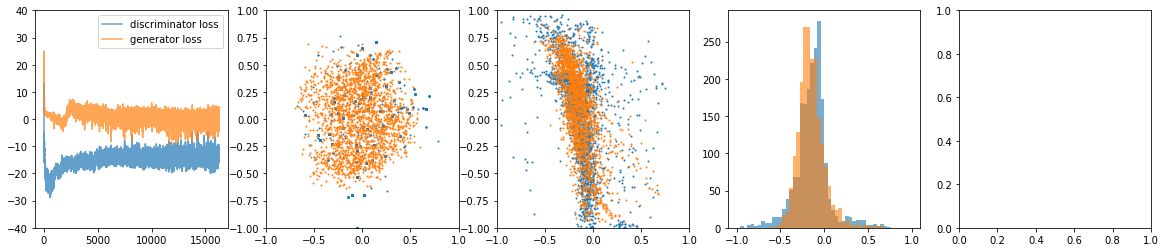

In [ ]:
from IPython.display import clear_output
import time

def do_training(epochs):
    global total_its
    global n_epochs
    global gamma

    start_time = time.time()
    last_time = time.time()

    gen.train()
    disc.train()

    _noise_strength = 0.0

    for j in range(epochs):
        its_per_epoch = chunked.shape[2] // batch_size
        for i in range(its_per_epoch):
            if (_noise_strength > 0.0):
                _noise_strength -= 1 / 5000
            else:
                _noise_strength = 0.0

            gamma *= 0.9998

            # Sample
            real = sample_real(batch_size).requires_grad_(True)
            fake = sample_fake(batch_size)

            #_noise = torch.randn_like(real) * _noise_strength

            real = real + torch.randn_like(real) * _noise_strength
            fake = fake + torch.randn_like(real) * _noise_strength

            # Discriminator's loss, based on two things:
            #  - Number of fake samples misidentified as real
            #  - Number of real samples misidentified as fake
            optimizer_disc.zero_grad()
            disc.zero_grad()

            
            true_disc_out = disc(real)
            #true_disc_loss = loss(true_disc_out, 0.9 + 0.1 * torch.rand((batch_size), device='cuda'))

            #print("it:", i) 
            
            gen_disc_out = disc(fake)
            #gen_disc_loss = loss(gen_disc_out, 0.1 * torch.rand((batch_size), device='cuda'))
            
            gp = gradient_penalty(disc, real, fake)

            d_loss = -torch.mean(true_disc_out) + torch.mean(gen_disc_out) + lambda_gp * gp
            #d_loss = -torch.mean(nn.functional.logsigmoid(true_disc_out) + torch.log(1. - torch.sigmoid(gen_disc_out)))

            #d_loss += gamma / 2 * disc_regularizer(true_disc_out, real, gen_disc_out, fake)
            #return

            d_loss.backward()

            optimizer_disc.step()
            


            # Train gen, keep disc fixed
            optimizer_gen.zero_grad()
            gen.zero_grad()
            
            gen.train()
            disc.train()
            #if (total_its > bn_turn_on):
            #    disc.eval()
            

            if i % n_critic == 0:
                fake = sample_fake(batch_size)
                fake = fake + torch.randn_like(real) * _noise_strength

                gen_disc_out = disc(fake)
                #g_loss = torch.mean(-nn.functional.logsigmoid(gen_disc_out))
                g_loss = -torch.mean(gen_disc_out)
                #g_loss = nn.functional.binary_cross_entropy(gen_disc_out, torch.ones_like(gen_disc_out))

                g_loss.backward()
                optimizer_gen.step()

                discriminator_losses.append(d_loss.item())
                generator_losses.append(g_loss.item())
            
            total_its += 1

            # Display progress
            progress_rate = 50
            if (i+1) % progress_rate == 0:
                
                clear_output(wait=True)
                
                print("d_loss:", d_loss)

                print(str(its_per_epoch - i - 1) + " iterations remaining.")
                print("Samples seen: " + str(len(discriminator_losses) * batch_size), 
                    "  Epochs:", str(len(discriminator_losses) * batch_size // chunked.shape[2]))
                cur_time = time.time()
                elapsed = cur_time - last_time
                print("%d its: %.1f seconds" % (progress_rate, elapsed))

                last_time = cur_time
                plt.clf()
                fig, axes = plt.subplots(1, 5, figsize=(20, 4))
                ax = axes[0]
                ax.plot(discriminator_losses, label='discriminator loss', alpha=0.7)
                ax.plot(generator_losses    , label='generator loss', alpha=0.7)
                ax.legend()
                ax.set(ylim=(-40, 40))

                ax = axes[1]
                gen.eval()
                with torch.no_grad():
                    _real = sample_real(1, noise_strength=0.0).cpu().detach().numpy()
                    _fake = sample_fake(1).cpu().detach().numpy()
                    ax.scatter(_real[:, 3], _real[:,4], s=1)
                    ax.scatter(_fake[:, 3], _fake[:,4], s=1)
                    ax.set(ylim=(-1, 1), xlim=(-1, 1))

                    ax = axes[2]
                    ax.scatter(_real[:, 0], _real[:,2], s=1)
                    ax.scatter(_fake[:, 0], _fake[:,2], s=1)
                    ax.set(ylim=(-1, 1), xlim=(-1, 1))

                    ax = axes[3]
                    ax.hist(_real[:,0].flatten(), bins=50, range=[-1,1], alpha=0.6);
                    ax.hist(_fake[:,0].flatten(), bins=50, range=[-1,1], alpha=0.6);
                    #_embed_w = disc.get_embed().weight.detach().cpu().numpy()
                    #plt.imshow(_embed_w.T, aspect=200, interpolation='none', cmap='inferno')
                    #plt.subplot(144)
                    #plt.imshow((_embed_w - _orig_embed_weights).T, aspect=200, interpolation='none', cmap='coolwarm')
                    #plt.colorbar()

                plt.show()
                gen.train()

        n_epochs += 1
        if (n_epochs % 10 == 0):
            save_states('8d72fe1', n_epochs, '/content/drive/My Drive/gan_states')

    end_time = time.time()
    elapsed = end_time - start_time

    print("%d iterations took %.1f seconds. Total its: %d. Epochs: %d" % (its_per_epoch * epochs, elapsed, total_its, n_epochs))

do_training(160);

In [806]:
 from google.colab import drive
import os
if os.path.exists('/content/drive') == False:
    drive.mount('/content/drive')

def save_states(version, epoch, path):
    states = { 'disc': disc.state_dict(), 'd_opt': optimizer_disc.state_dict(), 'd_loss': discriminator_losses,
               'gen': gen.state_dict(), 'g_opt': optimizer_gen.state_dict(), 'g_loss': generator_losses, 'n_epochs': epoch }
    torch.save(states, path + '/states_%s_%de.pt' % (version, epoch))
    print("saved to", path + '/states_%s_%de.pt' % (version, epoch))
def load_states(path):
    states = torch.load(path)
    disc.load_state_dict(states['disc'])
    optimizer_disc.load_state_dict(states['d_opt'])
    global discriminator_losses
    discriminator_losses = states['d_loss']
    gen.load_state_dict(states['gen'])
    optimizer_gen.load_state_dict(states['g_opt'])
    global generator_losses
    generator_losses = states['g_loss']
    global n_epochs
    n_epochs = states['n_epochs']
    print('done')

save_states('8d72fe1', n_epochs, '/content/drive/My Drive/gan_states')
#load_states('/content/drive/My Drive/gan_states/states_5393690+1_40e.pt')

saved to /content/drive/My Drive/gan_states/states_8d72fe1_20e.pt


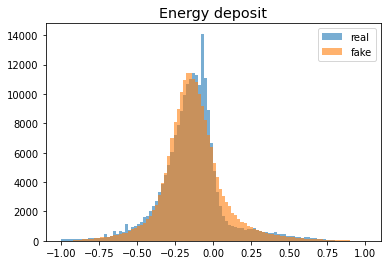

In [907]:
gen.eval()
result_real = sample_real(100, noise_strength=0.0)
result_fake = sample_fake(100)
plt.hist(result_real[:,0].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='real', density=False, range=[-1,1])
plt.hist(result_fake[:,0].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='fake', density=False, range=[-1,1])
#plt.yscale('log')
plt.legend()
plt.title("Energy deposit")
plt.show()

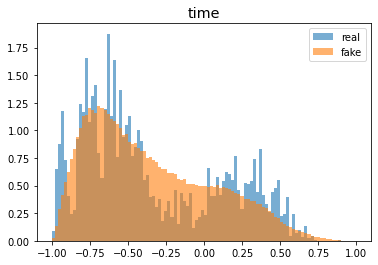

In [908]:
plt.hist(result_real[:,1].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='real', density=True, range=[-1, 1])
plt.hist(result_fake[:,1].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='fake', density=True, range=[-1, 1])
plt.title("time")
plt.legend()
plt.show()

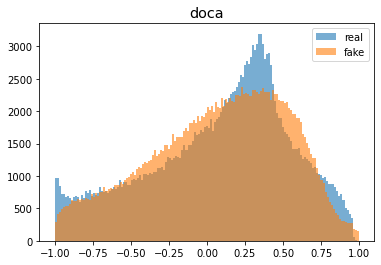

In [909]:
plt.hist(result_real[:,2].flatten().cpu().detach().numpy(), bins=150, alpha=0.6, label='real', density=False,)# range=[-1,1])
plt.hist(result_fake[:,2].flatten().cpu().detach().numpy(), bins=150, alpha=0.6, label='fake', density=False,)# range=[-1,1]
#plt.yscale('log')
plt.legend()
plt.title("doca")
plt.show()

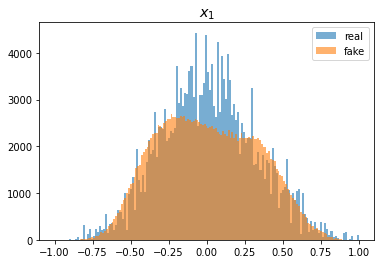

In [910]:
plt.hist(result_real[:,4].flatten().cpu().detach().numpy(), bins=150, alpha=0.6, label='real', density=False,)# range=[-1,1])
plt.hist(result_fake[:,4].flatten().cpu().detach().numpy(), bins=150, alpha=0.6, label='fake', density=False,)# range=[-1,1]
#plt.yscale('log')
plt.legend()
plt.title(r"$x_1$")
plt.show()

In [911]:
def get_random_real(n, i=None):
    if i is None:
        i = np.random.randint(0, wx.size - n)
    real_wire = wire[i:i+n]
    real_edep = edep[i:i+n]
    real_t = t[i:i+n]
    real_emb = embedded_wire[i:i+n]
    real_doca = doca[i:i+n]
    return real_wire, real_edep, real_t, real_emb, real_doca

def get_random_fake_seq(n):
    gen.eval()
    with torch.no_grad():
        fake_seq = sample_fake(n)
        print(fake_seq.shape)
        fake_seq = minmax_descale(fake_seq, train_min, train_max)
        edep = torch.pow(10, fake_seq[:,0])
        t = torch.pow(10, fake_seq[:,1])
        doca = fake_seq[:,2]
        emb = fake_seq[:,3:]
        return edep, t, doca, emb
get_random_fake_seq(2)

def get_random_fake(n):
    edep, t, doca, emb = get_random_fake_seq(n // hit_group_size)
    edep = edep.detach().cpu()
    t = t.detach().cpu()
    doca = doca.detach().cpu()
    emb = emb.detach().cpu()
    return edep.flatten(), t.flatten(), doca.flatten(), emb.permute(1, 0, 2).flatten(1, 2)
#__edep, __t, __doca, __emb = get_random_fake(2048)
#plt.hist(__emb[2].detach().cpu(), bins=50);


torch.Size([2, 16, 2048])


(2048,)
torch.Size([1, 16, 2048])
torch.Size([13, 2048]) torch.Size([1, 2048]) torch.Size([4986, 13])
torch.Size([4986, 1])
unique real: 138  fake: 621


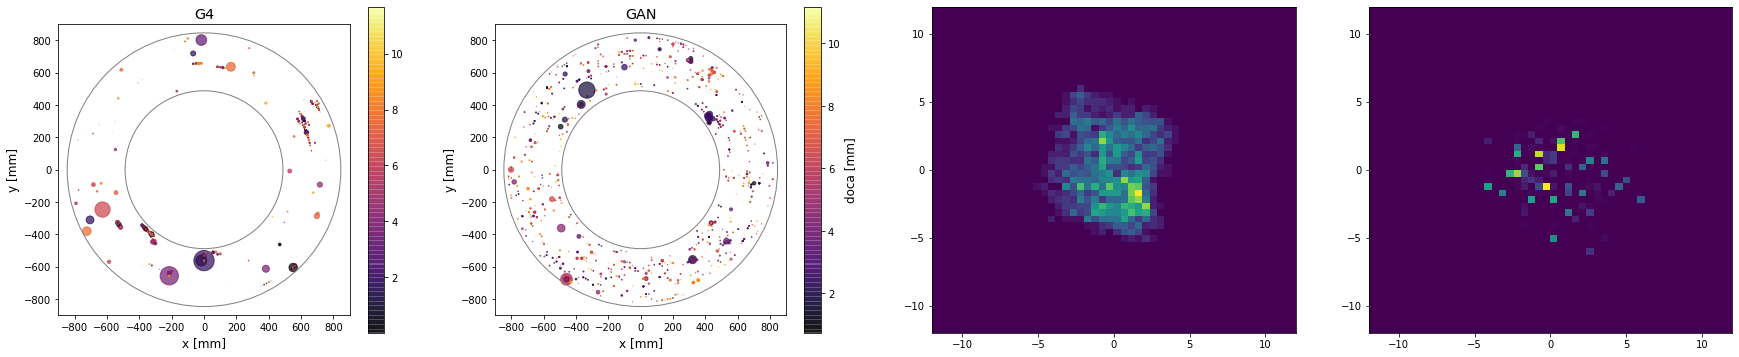

In [925]:
def compare(n_hits):
    plt.figure(figsize=(30,6))

    real_wire, real_edep, real_t, real_emb, real_doca = get_random_real(n_hits)
    print(real_wire.shape)
    plt.subplot(141)
    plt.title('G4')
    only_walls(plt.gca())
    plt.gca().set_aspect(1)
    plt.scatter(wire_x[real_wire], wire_y[real_wire], s=real_edep * 5e2, alpha=0.7, c=real_doca, cmap='inferno')
    plt.colorbar();

    fake_edep, fake_t, fake_doca, embed_pos = get_random_fake(n_hits)

    plt.subplot(143)
    _range = 12
    plt.hist2d(embed_pos[2].numpy(), embed_pos[1].numpy(), bins=50, density=True, range=[[-_range, _range], [-_range, _range]]);
    plt.subplot(144)
    plt.hist2d(real_emb[:,2].detach().cpu().numpy(), real_emb[:,1].detach().cpu().numpy(), bins=50, density=True, range=[[-_range, _range], [-_range, _range]]);
    #plt.hist(embedded_wire[:,0].detach().cpu(), bins=50, density=True);
    
    pos_norm = torch.norm(embed_pos, dim=0, keepdim=True)
    print(embed_pos.shape, pos_norm.shape, model.embed.weight.data.shape)
    weights = model.embed.weight.data.detach()
    weight_norm = torch.norm(weights, dim=1, keepdim=True)
    print(weight_norm.shape)

    #dist = torch.tensordot((embed_pos / pos_norm).T, (weights / weight_norm).T, dims=1)
    #dist = torch.tensordot((embed_pos / 1).T, (weights / 1).T, dims=1)
    #nearest = torch.argmax(dist, dim=1)
    dist = torch.cdist(embed_pos.T, weights, p=2)
    nearest = torch.argmin(dist, dim=1)
    
    #print(dist.shape) # n_hit, 4986
    
    # Requires context hits
    # lin = model.lin1(embed_pos)
    # print(lin)
    # return

    #nearest = torch.multinomial(dist, 1, replacement=True).squeeze()
    #print(nearest.shape) # n_hit
    #return
    
    #print(dot.shape) # n_hit, 4986
    #print(nearest.shape) # n_hit

    plt.subplot(142)
    plt.title('GAN')
    only_walls(plt.gca())
    plt.gca().set_aspect(1)
    plt.scatter(wire_x[nearest], wire_y[nearest], s=fake_edep*5e2, alpha=0.7, c=fake_doca, cmap='inferno')
    plt.colorbar(label='doca [mm]');

    print('unique real: %d  fake: %d' % (np.unique(real_wire).size, np.unique(nearest).size))

compare(2048)

torch.Size([1024, 16, 2048])
torch.Size([1024, 13, 2048])


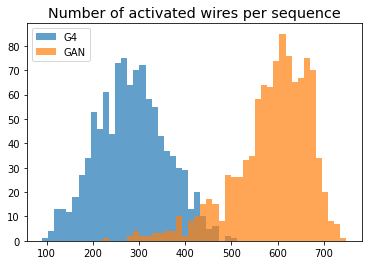

In [919]:
def activated_wires(n_seq):
    fake_edep, fake_t, fake_doca, embed_pos = get_random_fake_seq(n_seq)
    print(embed_pos.shape)

    weights = to_device(model.embed.weight.data.detach())

    n_fake_uq = []
    n_real_uq = []
    for i in range(n_seq):
        real_wire, real_edep, real_t, real_emb, real_doca = get_random_real(hit_group_size)

        #pos_norm = torch.norm(embed_pos[i], dim=0, keepdim=True)
        dist = torch.cdist(embed_pos[i].T, weights, p=2)
        nearest = torch.argmin(dist, dim=1)
        n_fake_uq.append(np.unique(nearest.cpu()).size)
        n_real_uq.append(np.unique(real_wire).size)
    #print(n_fake_uq)
    
    plt.hist(n_real_uq, bins=50, range=[min(min(n_fake_uq), min(n_real_uq)), max(max(n_fake_uq), max(n_real_uq))], alpha=0.7, label='G4');
    plt.hist(n_fake_uq, bins=50, range=[min(min(n_fake_uq), min(n_real_uq)), max(max(n_fake_uq), max(n_real_uq))], alpha=0.7, label='GAN');
    plt.legend()
    plt.title('Number of activated wires per sequence')

activated_wires(1024)

### MSE and SSIM distributions

In [920]:
#MSE
def mse_dist():
    real = chunked[:,:,::hit_group_size//hit_group_stride] # 6, 1024, n_seq
    #print(real.shape)
    n_samples = real.shape[2]
    with torch.no_grad():
        fake = sample_fake(n_samples).permute(1, 2, 0) # 6, 1024, n_samples
        
        print("min: ", real.min(dim=1).values.min(dim=1).values.detach().cpu(), fake.min(dim=1).values.min(dim=1).values.detach().cpu())
        print("max: ", real.max(dim=1).values.max(dim=1).values.detach().cpu(), fake.max(dim=1).values.max(dim=1).values.detach().cpu())

        print("mean: ", real.mean(dim=1).mean(dim=1).detach().cpu(), fake.mean(dim=1).mean(dim=1).detach().cpu())

        mse_arr = []
        for i in range(n_samples):
            ch = fake[:,:,i]
            #print(ch.unsqueeze(2).shape)
            mse = torch.mean((ch.unsqueeze(2) - real)**2)
            mse_arr.append(mse.item())
            #print(mse.shape, mse)
        #plt.hist(mse_arr, bins=50)
        print("avg %.3f  sqrt %.3f" % (np.mean(mse_arr), np.sqrt(np.mean(mse_arr))))
        print("min %.3f" % (np.min(mse_arr)))

        return mse_arr
        #mse_edep = real_edep - fake_edep
_fake_mse = mse_dist()

min:  tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.]) tensor([-0.9612, -0.9985, -0.9997, -0.9468, -0.9063, -0.9405, -0.8578, -0.9537,
        -0.9060, -0.9210, -0.9285, -0.9802, -0.9402, -0.9118, -0.9218, -0.8950])
max:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) tensor([0.9799, 0.9308, 0.9985, 0.9257, 0.9240, 0.9383, 0.9463, 0.8799, 0.8778,
        0.8475, 0.9527, 0.9585, 0.7582, 0.9383, 0.9028, 0.8897])
mean:  tensor([-0.1400, -0.3403,  0.0775, -0.0386,  0.0145,  0.0315,  0.0936,  0.0048,
         0.0460, -0.1226, -0.0458,  0.0196, -0.1520,  0.0007, -0.0592, -0.0518]) tensor([-0.1301, -0.3472,  0.0786, -0.0305,  0.0073,  0.0297,  0.0885,  0.0095,
         0.0536, -0.1148, -0.0532,  0.0181, -0.1468,  0.0249, -0.0589, -0.0693])
avg 0.194  sqrt 0.440
min 0.172


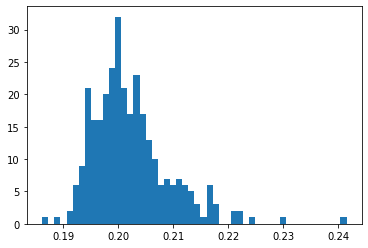

In [921]:
def mse_dist_real():
    real = chunked[:,:,::hit_group_size//hit_group_stride] # 6, 1024, n_seq
    n_samples = real.shape[2]
    mse_arr = []
    for i in range(n_samples):
        mask = torch.full((real.shape[2],), True, dtype=torch.bool)
        mask[i] = False
        mse = torch.mean((real[:,:,i].unsqueeze(2) - real[:,:,mask])**2)
        
        mse_arr.append(mse.item())
    plt.hist(mse_arr, bins=50);
    return mse_arr
_real_mse = mse_dist_real()

min:  tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.]) tensor([-0.9828, -0.9991, -0.9999, -0.9536, -0.9184, -0.9374, -0.8232, -0.9609,
        -0.9217, -0.8902, -0.9394, -0.9889, -0.9710, -0.9060, -0.9595, -0.8586])
max:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) tensor([0.9839, 0.9487, 0.9999, 0.9247, 0.9293, 0.9219, 0.9523, 0.8483, 0.8669,
        0.8482, 0.9417, 0.9410, 0.8028, 0.9826, 0.9207, 0.8667])
mean:  tensor([-0.1400, -0.3403,  0.0775, -0.0386,  0.0145,  0.0315,  0.0936,  0.0048,
         0.0460, -0.1226, -0.0458,  0.0196, -0.1520,  0.0007, -0.0592, -0.0518]) tensor([-0.1303, -0.3493,  0.0774, -0.0303,  0.0069,  0.0298,  0.0883,  0.0096,
         0.0535, -0.1145, -0.0530,  0.0183, -0.1471,  0.0247, -0.0588, -0.0693])
avg 0.195  sqrt 0.441
min 0.173


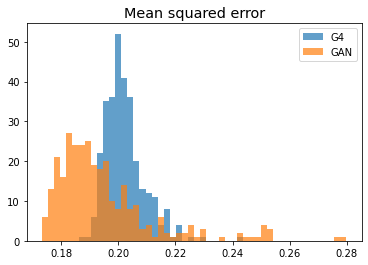

In [922]:
_fake_mse = mse_dist()
plt.title('Mean squared error')
_range = [min(min(_real_mse), min(_fake_mse)), max(max(_real_mse), max(_fake_mse))]
plt.hist(_real_mse, bins=50, label='G4', range=_range, alpha=0.7);
plt.hist(_fake_mse, bins=50, label='GAN', range=_range, alpha=0.7);
plt.legend();

In [738]:
def neighbors():
    # For each hit, check how many other hits occurred on the neighboring wires
    # Plot the distribution of that number
    return
neighbors()

torch.Size([6, 1024, 613])
(613, 6)
(613, 6)
(613, 6)
(613, 6)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


(613, 6)
(613, 6)
(613, 6)
(613, 6)
(613, 6)
(613, 6)
(613, 6)
(613, 6)
(613, 6)
(613, 6)
(613, 6)
(613, 6)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6630: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6631: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: ignored

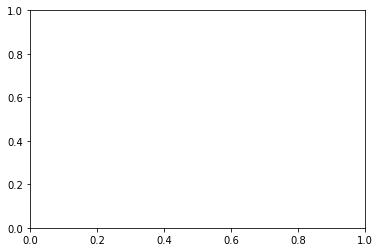

In [ ]:
# TODO what if our window is the whole sequence?
def ssim():
    real = chunked[:,:,::hit_group_size//hit_group_stride] # 6, 1024, n_seq
    print(real.shape)
    n_samples = 16
    fake = sample_fake(n_samples).permute(1, 2, 0) # 6, 1024, n_samples
    ssim_means = []

    window_size = 64
    real_windows = real.unfold(1, window_size, 1)

    for i in range(n_samples):
        ch = fake[:,:,i]
        #print(ch.shape)
        
        fake_window = ch.unfold(1, window_size, 1).unsqueeze(2)
        #print(fake_window.shape, real_windows.shape)
        
        #diff = fake_window - real_windows
        #print(diff.shape)
        mu_x = fake_window.mean(dim=3, keepdim=True)
        mu_y = real_windows.mean(dim=3, keepdim=True)
        var_x = fake_window.var(dim=3, keepdim=True)
        var_y = real_windows.var(dim=3, keepdim=True)
        #print(var_x.shape)
        #print(var_y.shape)
        #print((fake_window - mu_x).shape, (real_windows - mu_y).shape)

        ssim_arr = []
        for j in range(real_windows.shape[2]):
            covar = torch.tensordot((fake_window[:,:,0] - mu_x[:,:,0]), (real_windows[:,:,j] - mu_y[:,:,j]), dims=[[2], [2]]).mean(dim=3, keepdim=True).mean(dim=2, keepdim=True)
            #print(covar.shape, var_x.shape, var_y.shape)
            ssim = (2. * mu_x[:,:,0] * mu_y[:,:,j]) * (2. * covar[:,:,0]) / ((mu_x[:,:,0]**2 * mu_y[:,:,j]**2) * (var_x[:,:,0] * var_y[:,:,j]))
            # Average over all windows
            ssim = ssim.squeeze().mean(dim=1)
            #print(ssim.shape)
            ssim_arr.append(ssim.tolist())
        
        ssim_arr = np.array(ssim_arr)
        print(ssim_arr.shape)
        ssim_means.append(np.mean(ssim_arr))
    plt.hist(ssim_means, bins=50)
    print("%e" % (np.mean(ssim_means)))
    return ssim_means
__means = ssim()

## Feature matrices

torch.Size([100, 16, 2048])


<Figure size 432x288 with 0 Axes>

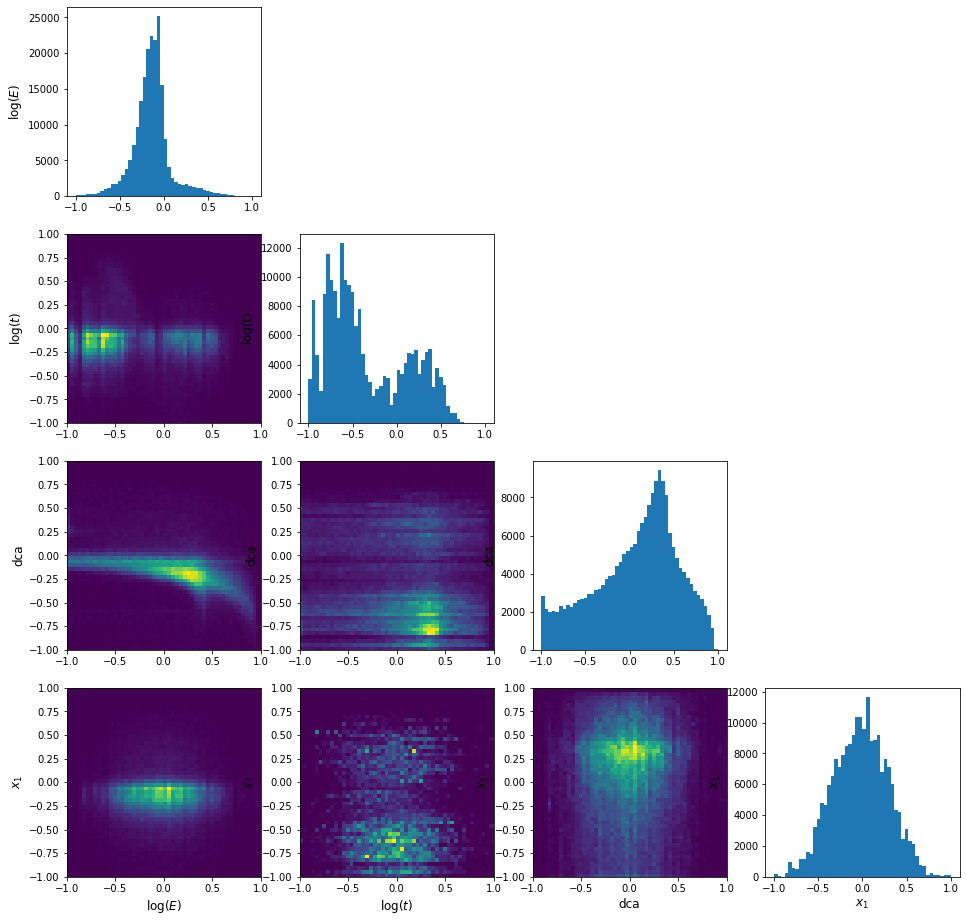

In [923]:
# Feature correlation matrix
def feature_correlation_matrix(n_feat):
    plt.tight_layout()
    fig, axes = plt.subplots(n_feat, n_feat, figsize=(16,16))
    axis_labels = [r'log($E$)', r'log($t$)', 'dca', r'$x_1$']
    for i in range(n_feat):
        for j in range(n_feat):
            ax = axes[i][j]
            ax.set(ylabel=axis_labels[i])
            if i == n_feat - 1:
                ax.set(xlabel=axis_labels[j])
                
            if j == i:
                ax.hist(result_real[:,i].flatten().cpu().detach().numpy(), bins=50, range=[-1,1])
            else:
                _x = result_real[:,i].flatten().cpu().detach().numpy()
                _y = result_real[:,j].flatten().cpu().detach().numpy()
                if i > j:
                    ax.hist2d(_x, _y, bins=50, range=[[-1, 1], [-1, 1]])
                else:
                    ax.remove()
                #    ax.hist2d(_x, _y, bins=50, range=[[-1, 1], [-1, 1]], norm=mcolors.PowerNorm(0.5))
    print(result_real.shape)
feature_correlation_matrix(4);

torch.Size([100, 16, 2048])


<Figure size 432x288 with 0 Axes>

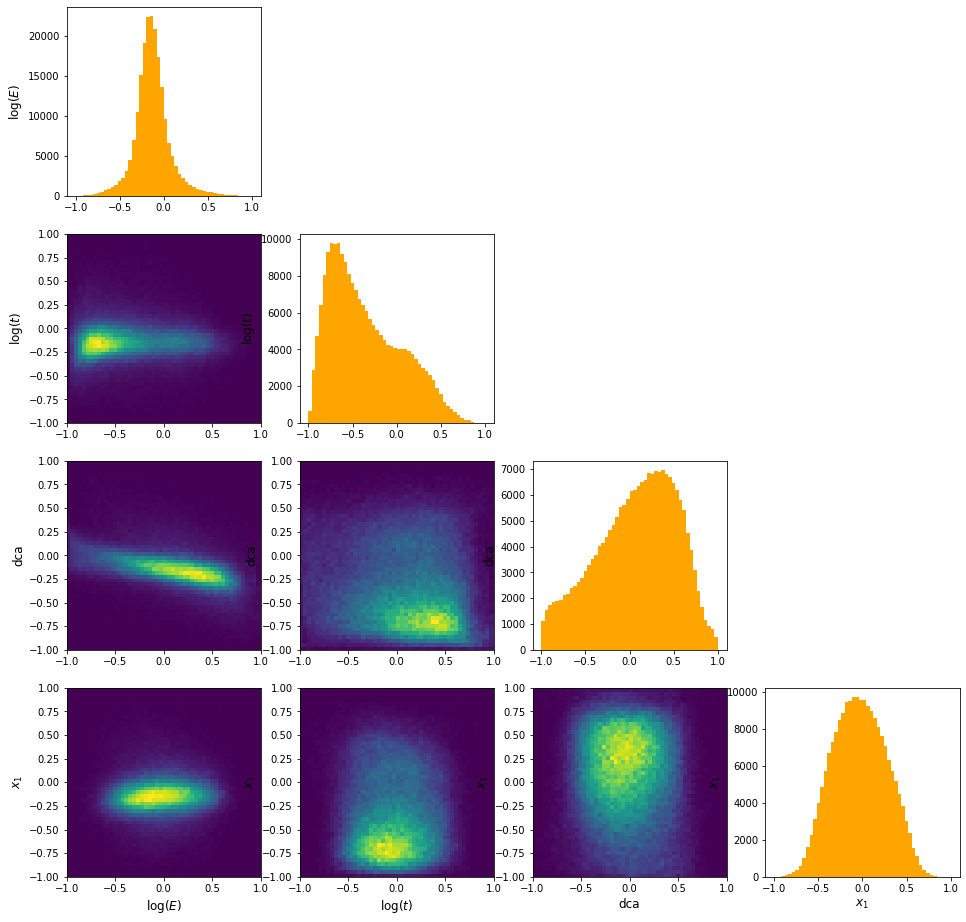

In [924]:
# Feature correlation matrix
def feature_correlation_matrix_fake(n_feat):
    plt.tight_layout()
    fig, axes = plt.subplots(n_feat, n_feat, figsize=(16,16))
    axis_labels = [r'log($E$)', r'log($t$)', 'dca', r'$x_1$']
    for i in range(n_feat): # row
        for j in range(n_feat): # column
            ax = axes[i][j]
            ax.set(ylabel=axis_labels[i])
            if i == n_feat - 1:
                ax.set(xlabel=axis_labels[j])

            if j == i:
                ax.hist(result_fake[:,i].flatten().cpu().detach().numpy(), bins=50, range=[-1,1], color='orange')
            else:
                _x = result_fake[:,i].flatten().cpu().detach().numpy()
                _y = result_fake[:,j].flatten().cpu().detach().numpy()

                
                
                if i > j:
                    ax.hist2d(_x, _y, bins=50, range=[[-1, 1], [-1, 1]])
                else:
                    ax.remove()
                    #ax.hist2d(_x, _y, bins=50, range=[[-1, 1], [-1, 1]], norm=mcolors.PowerNorm(0.5))
                
    print(result_real.shape)
feature_correlation_matrix_fake(4);

Scores table
---

| epochs | embed dims | ndf | ngf | latent dims | commit | avg(mse) | ssim | comment|
|---|---|---|---|---|---|---|---|---|
| 1-2 | 3 | 16 | 16 | 16 | ? | ~~1e12~~ | | |
| 1 | 3 | 48 | 32 | 256 | ? | ~~4e6~~ | | |
| 1 | 3 | 48 | 32 | 256 | ? | ~~4e6~~ | | no gamma |
| 1 | 3 | 8 | 8 | 128 | ? | ~~7e10~~ | | multi-mode latent space |
| 3 | 3 | 16 | 16 | 128 | ? | 0.242 |  | multi-mode latent space |
| 3 | 7 | 16 | 16 | 128 | ? | 0.227 |  | too many wires light up (BN in gen) |
| 3 | 7 | 16 | 16 | 128 | ? | 0.237 |  | no BN in gen, results are nice |
| 3 | 7 | 16 | 16 | 128 | ? | 0.235 |  | InstanceNorm in gen, results are nice but too noisy |
| 22 | 7 | 16 | 16 | 128 | ? | 0.247 |  | InstanceNorm in gen, results are nice but too noisy |
| 3 | 7 | 16 | 16 | 128 | ? | 0.212 |  | InstanceNorm in G and D, still noisy. Stable training |
| 12 | 7 | 16 | 16 | 128 | ? | 0.212 |  | InstanceNorm in G and D, still noisy. Stable training |

### Activated wires per sequence

### Grid of samples for a reduced region of phase space

torch.Size([2, 100])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torch.Size([1, 1024, 2])
torch.Size([1, 4986, 2]) torc

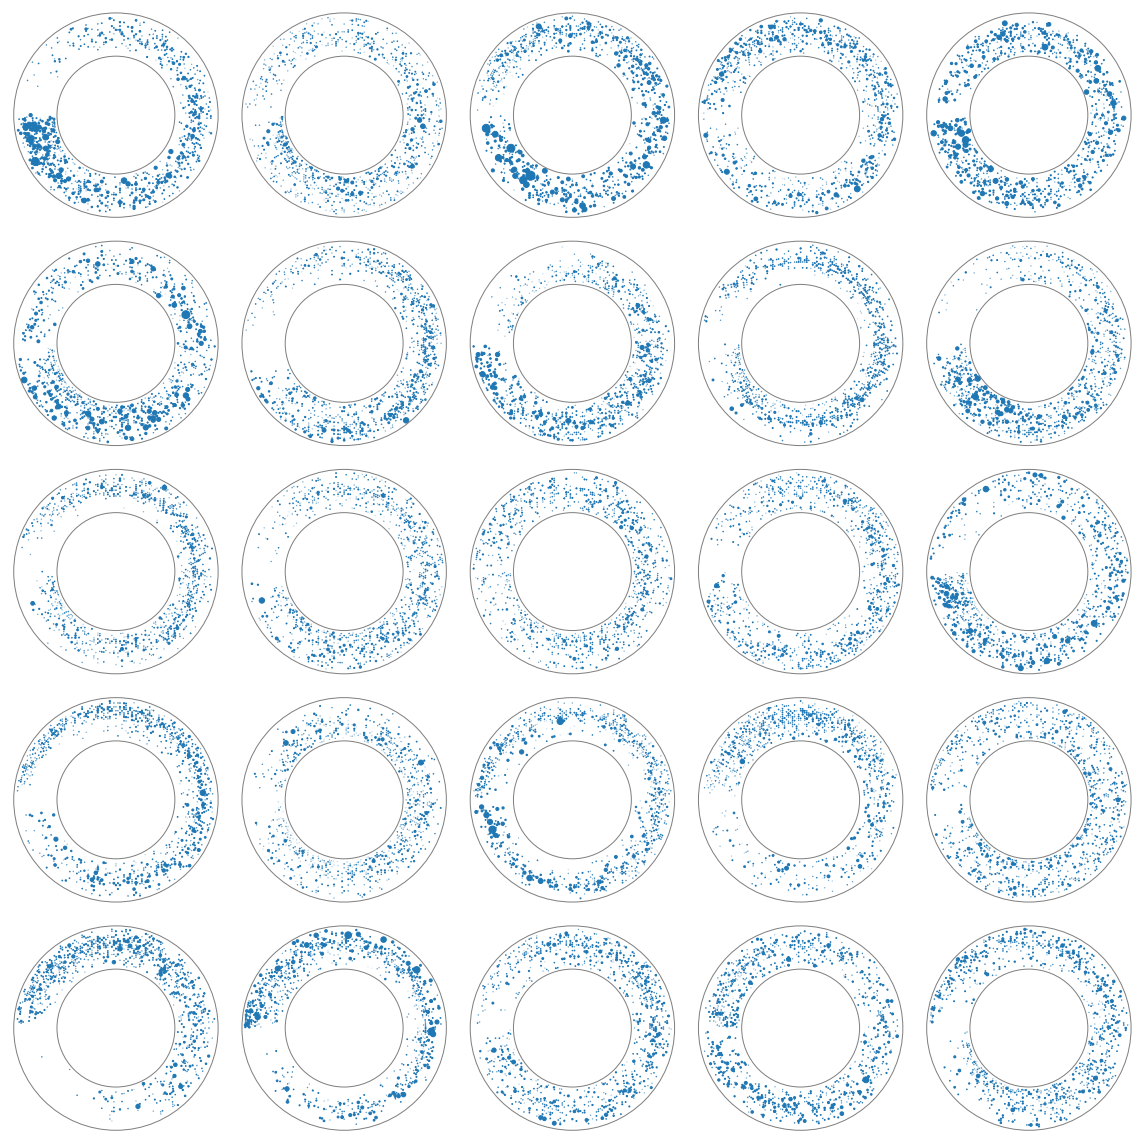

In [ ]:
# Select two latent space dimensions and explore the range
dim0 = 0
dim1 = 1
step = 0.2
plt.figure(figsize=(16,16))

nrows = int(1 / step)
ncols = int(1 / step)

def get_sample(N_hits, latent_pos):
    fake_tensor = disc.reverse_embed(gen(latent_pos)[:1]).permute(0, 2, 1).flatten(0, 1)
    fake_hits = inv_transform(fake_tensor.T)
    fake_wire = fake_hits[3].astype(int)
    fake_edep = fake_hits[0]
    return fake_wire, fake_edep

compare_N_hits = hit_group_size*2#1 * chunked.shape[2] // int(n_bunches)
latent_pos = torch.zeros((compare_N_hits // hit_group_size, latent_dims), device='cuda')
print(latent_pos.shape)
for i in range(nrows):
    for j in range(ncols):
        plt.subplot(nrows, ncols, i*nrows + j + 1, frameon=False)
        
        
        latent_pos[:,dim0] = i / (nrows-1) * 2 - 1
        latent_pos[:,dim1] = j / (ncols-1) * 2 - 1
        _wire, _edep = get_sample(compare_N_hits, latent_pos)
        
        only_walls(plt.gca())
        plt.xlabel('')
        plt.ylabel('')
        plt.gca().axis('off')
        
        plt.scatter(wire_x[_wire[:1024]], wire_y[_wire[:1024]], s=np.power(10, _edep[:1024]) * 1e3);
    
    
plt.tight_layout()
plt.savefig('GAN_gen_grid.png', dpi=120)

In [ ]:
torch.save(gen, "gen_8b21a0d_10e.pt")

In [ ]:
torch.save(disc, "disc_8b21a0d_10e.pt")

In [ ]:
!wget http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/disc_8b21a0d_10e.pt http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/gen_8b21a0d_10e.pt

--2020-09-11 07:39:38--  http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/disc_8b21a0d_10e.pt
Resolving www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)... 146.179.108.103, 2a0c:5bc0:88:111:216:3eff:fe7f:177
Connecting to www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)|146.179.108.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6322712 (6.0M)
Saving to: ‘disc_8b21a0d_10e.pt’

disc_8b21a0d_10e.pt 100%[===================>]   6.03M  --.-KB/s    in 0.1s    

2020-09-11 07:39:38 (40.4 MB/s) - ‘disc_8b21a0d_10e.pt’ saved [6322712/6322712]

--2020-09-11 07:39:38--  http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/gen_8b21a0d_10e.pt
Reusing existing connection to www.hep.ph.ic.ac.uk:80.
HTTP request sent, awaiting response... 200 OK
Length: 4006614 (3.8M)
Saving to: ‘gen_8b21a0d_10e.pt’

gen_8b21a0d_10e.pt  100%[===================>]   3.82M  --.-KB/s    in 0.1s    

2020-09-11 07:39:38 (31.7 MB/s) - ‘gen_8b21a0d_10e.pt’ saved [4006614/4006614]

FINISHED --2020-09-11 07:39:38--
Total wall

In [ ]:
_disc = torch.load("/content/disc_8b21a0d_10e.pt")

In [ ]:
_disc

Disc256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (from_feature): ConvEQ(6, 25, kernel_size=(1,), stride=(1,))
  (conv1_1): ConvEQ(25, 25, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): ConvEQ(25, 25, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): ConvEQ(25, 50, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvEQ(50, 50, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvEQ(50, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvEQ(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn5): BatchNo

In [ ]:
disc = _disc

In [ ]:
_gen = torch.load("/content/gen_8b21a0d_10e.pt")

In [ ]:
_gen

Gen256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (lin1): Linear(in_features=100, out_features=96, bias=True)
  (lin2): Linear(in_features=96, out_features=400, bias=True)
  (lin3): Linear(in_features=400, out_features=1600, bias=True)
  (bn0): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): ConvTransposeEQ(100, 192, kernel_size=(3,), stride=(1,), padding=(1,))
  (ups1): Upsample(scale_factor=2.0, mode=nearest)
  (norm1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTransposeEQ(192, 192, kernel_size=(3,), stride=(1,), padding=(1,))
  (norm2): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTransposeEQ(192, 96, kernel_size=(3,), stride=(1,), padding=(1,))
  (norm3): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTransposeEQ(96, 96, kernel_size=(3,), stride=(1,), padding=(1,))
  (nor

In [ ]:
gen = _gen

### Radius distribution

In [ ]:
wx.size // n_bunches // 128

79.0

In [ ]:
compare_N_hits = int(wx.size // n_bunches * 10)#chunked.shape[2]
print(compare_N_hits)

fake_tensor = disc.reverse_embed(sample_fake(compare_N_hits // hit_group_size)).permute(0, 2, 1).flatten(0, 1)
fake_hits = inv_transform(fake_tensor.T)
fake_wire = fake_hits[3]
fake_doca = fake_hits[2]
fake_edep = fake_hits[0]
fake_t = fake_hits[1]

#fake_wire_idx = find_closest_wire(fake_wx, fake_wy)
fake_wire_idx = fake_wire.astype('long')


#real_tensor = train[:4,:compare_N_hits // 4].flatten(0, 1)
#real_tensor = real_tensor.clone()
#real_tensor += 0.015 * torch.randn_like(real_tensor)
#real_hits = inv_transform(real_tensor.T)
real_wx = wx[:compare_N_hits]
real_wy = wy[:compare_N_hits]
real_edep = np.log10(edep[:compare_N_hits])
real_doca = doca[:compare_N_hits]
real_t = np.log10(t[:compare_N_hits])

real_wire_idx = find_closest_wire(real_wx, real_wy)

101460


ModuleAttributeError: ignored

In [ ]:
plt.figure(figsize=(6, 4))
_r_real = np.sqrt(wire_x[real_wire_idx]**2 + wire_y[real_wire_idx]**2)
_r_fake = np.sqrt(wire_x[fake_wire_idx]**2 + wire_y[fake_wire_idx]**2)

counts, bins = np.histogram(_r_real, bins=20)
plt.bar(bins[:-1] - 2.5, counts, width=5, label='G4', alpha=0.8)
counts, bins = np.histogram(_r_fake, bins=20)
plt.bar(bins[:-1] + 2.5, counts, width=5, label='GAN', alpha=0.8)
#plt.hist(_r_real, bins=20, alpha=0.7, label='real');
#plt.hist(_r_fake, bins=20, alpha=0.7, label='fake');

plt.legend();
plt.title('G4 versus GAN, 15 bunches')
plt.xlabel('$r$ [mm]')
plt.savefig('radius_comp.png', dpi=120)

### Angular distribution on the last 3 layers to see potential square->circle transformation bias

In [ ]:
plt.figure(figsize=(6, 4))

_phi_real = np.arctan2(wire_y[real_wire_idx], wire_x[real_wire_idx])
_phi_fake = np.arctan2(wire_y[fake_wire_idx], wire_x[fake_wire_idx])
plt.hist(_phi_real, bins=100, alpha=0.7, label='G4', density=False)
plt.hist(_phi_fake, bins=100, alpha=0.7, label='GAN', density=False);

plt.title('GAN versus G4, 15 bunches')
plt.legend();
plt.xlabel(r'$\phi$ [rad]')
plt.savefig('phi_comp.png', dpi=120)

### Energy, time

In [ ]:
plt.figure(figsize=(6, 4))

plt.hist(real_edep, bins=100, alpha=0.7, label='G4', density=True)
plt.hist(fake_edep, bins=100, alpha=0.7, label='GAN', density=True);

plt.title('GAN versus G4, 15 bunches')
plt.legend();
plt.xlabel(r'log10(Energy deposit [MeV])')
#plt.savefig('phi_comp.png', dpi=120)

In [ ]:
plt.figure(figsize=(6, 4))

plt.hist(real_t, bins=100, alpha=0.7, label='G4')
plt.hist(fake_t, bins=100, alpha=0.7, label='GAN');

plt.title('GAN versus G4, 15 bunches')
plt.legend();
plt.xlabel(r'log10(t [ns])')


#plt.savefig('phi_comp.png', dpi=120)

In [ ]:
plt.figure(figsize=(6, 4))

plt.hist(real_doca, bins=100, alpha=0.7, label='G4')
plt.hist(fake_doca, bins=100, alpha=0.7, label='GAN');

plt.title('GAN versus G4, 15 bunches')
plt.legend();
plt.xlabel(r'doca [mm]')


#plt.savefig('phi_comp.png', dpi=120)

### Number of consecutive activated / empty wires

In [ ]:
num_layers = 20

def consecutive_hits(wire_idx):
    layer, wire = wire_abs_to_rel(wire_idx)
    sum_consec = np.zeros(num_layers)
    for i in range(num_layers):
        l_w = wire[layer == i]
        #print(wire)
        dist_mat = cdist(l_w[:, np.newaxis], l_w[:, np.newaxis])
        #plt.imshow(dist_mat)
        #plt.show()
        # !!! NOTE: I changed distance threshold to zero to see hit counts on the same wire
        sum_consec[i] = np.sum(dist_mat <= 1) / 2 / l_w.size
        #print(l_w.size, (dist_mat <= 1).shape)
        #print("avg dist at", i, " : ", dist_mat.mean())
        #print(dist_mat)
    return sum_consec
    
#plt.hist(sum_consec, range=[0,num_layers], bins=num_layers);

In [ ]:
compare_N_hits = int(wx.size // n_bunches)#chunked.shape[2]
print(compare_N_hits)

fake_tensor = disc.reverse_embed(sample_fake(compare_N_hits // hit_group_size)).permute(0, 2, 1).flatten(0, 1)
fake_hits = inv_transform(fake_tensor.T)
fake_wire = fake_hits[3]
fake_doca = fake_hits[2]
fake_edep = fake_hits[0]
fake_t = fake_hits[1]

print(fake_wire.size)

#fake_wire_idx = find_closest_wire(fake_wx, fake_wy)
fake_wire_idx = fake_wire.astype('long')


#real_tensor = train[:4,:compare_N_hits // 4].flatten(0, 1)
#real_tensor = real_tensor.clone()
#real_tensor += 0.015 * torch.randn_like(real_tensor)
#real_hits = inv_transform(real_tensor.T)
real_wx = wx[:compare_N_hits]
real_wy = wy[:compare_N_hits]
print(real_wx.size)
real_edep = np.log10(edep[:compare_N_hits])
real_doca = doca[:compare_N_hits]
real_t = np.log10(t[:compare_N_hits])

real_wire_idx = find_closest_wire(real_wx, real_wy)

In [ ]:
plt.hist(real_wire_idx, bins=50, alpha=0.7);
plt.hist(fake_wire_idx, bins=50, alpha=0.7);

In [ ]:
plt.figure(figsize=(6, 4))
#plt.subplot(121)

print("Real now")
real_consec = consecutive_hits(real_wire_idx)
#real_consec
plt.bar(np.arange(num_layers) - 0.175, real_consec, width=0.35, label='G4', alpha=0.8);
plt.xticks(np.arange(num_layers));

print("Fake now")
fake_consec = consecutive_hits(fake_wire_idx)
#fake_consec
plt.bar(np.arange(num_layers) + 0.175, fake_consec, width=0.35, label='GAN', alpha=0.8);
plt.xticks(np.arange(num_layers));

plt.legend();
plt.xlabel("CDC Layer")
plt.title("Number of adjacent hits per hit, 1 bunch")

plt.savefig('adjacent_comp.png', dpi=120)

In [ ]:
_total_consec_real = 0
_total_consec_fake = 0
for i in range(num_layers):
    l, w = wire_abs_to_rel(real_wire_idx)
    n_consec = (cdist(w[l == i][:,np.newaxis], w[l == i][:,np.newaxis]) <= 1.).sum()
    _total_consec_real += n_consec
    
    l, w = wire_abs_to_rel(fake_wire_idx)
    n_consec = (cdist(w[l == i][:,np.newaxis], w[l == i][:,np.newaxis]) <= 1.).sum()
    _total_consec_fake += n_consec
print("Careful, this number is probably not counted right (double counting)")
print("total real:", _total_consec_real, "  fake:", _total_consec_fake)

### Number of empty/full wires per layer

In [ ]:
num_layers = 20

def occupancy(wire_idx):
    layer, wire = wire_abs_to_rel(wire_idx)
    ret = np.zeros(num_layers)
    for i in range(num_layers):
        l_w = wire[layer == i]
        wires_in_layer = cum_n_wires[i+1] - cum_n_wires[i]
        empty = wires_in_layer - np.unique(l_w).size
        ret[i] = 1 - empty / wires_in_layer
        #sum_consec[i] = (dist_mat <= 1).sum() / 2 / l_w.size
        #print(dist_mat)
    return ret
    
#plt.hist(sum_consec, range=[0,num_layers], bins=num_layers);

In [ ]:
plt.figure(figsize=(6, 4))
#plt.subplot(121)

real_empty = occupancy(real_wire_idx)
#real_consec
plt.bar(np.arange(num_layers) - 0.175, real_empty, width=0.35, label='G4', alpha=0.8);
plt.xticks(np.arange(num_layers));

fake_empty = occupancy(fake_wire_idx)
#fake_consec
plt.bar(np.arange(num_layers) + 0.175, fake_empty, width=0.35, label='GAN', alpha=0.8);
plt.xticks(np.arange(num_layers));

plt.legend();
plt.xlabel("CDC Layer")
plt.title("Occupancy per layer, 1 bunch")

plt.ylim(0, 1);
plt.savefig('fraction_empty_comp.png', dpi=120)

In [ ]:
edep_per_wire = np.zeros(cum_n_wires[-1])
for i in range(cum_n_wires[-1]):
    edep_per_wire[i] = np.sum(real_edep[real_wire_idx == i])

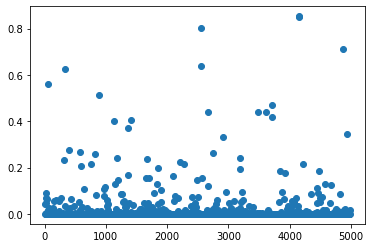

In [ ]:
plt.scatter(np.arange(cum_n_wires[-1])[edep_per_wire!=0], np.power(10, edep_per_wire)[edep_per_wire!=0]);

In [ ]:
edep_per_wire = np.zeros(cum_n_wires[-1])
for i in range(cum_n_wires[-1]):
    edep_per_wire[i] = np.sum(fake_edep[fake_wire_idx == i])

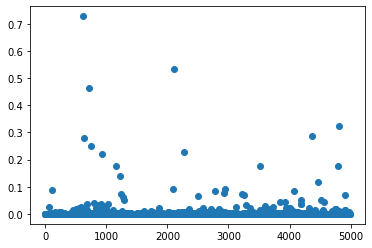

In [ ]:
plt.scatter(np.arange(cum_n_wires[-1])[edep_per_wire!=0], np.power(10, edep_per_wire)[edep_per_wire!=0]);

## Nearest neighbors

In [ ]:
chunked.detach().cpu().numpy().shape

(4, 1024, 156785)

In [ ]:
# Generate N samples and find their nearest neighbors in the training set
N = 10
fake_tensor = sample_fake(N).permute(0, 2, 1)
print(fake_tensor.shape)

torch.Size([10, 1024, 6])


RuntimeError: ignored

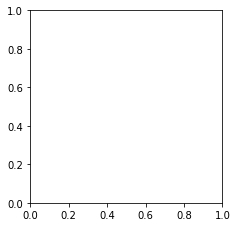

In [ ]:
from scipy.spatial.distance import euclidean

def nearest_neighbor(fake):
    real = chunked.permute(2, 1, 0)
    #print(real.shape)
    #print((real - fake[np.newaxis,:]).shape)
    dist = torch.sqrt((real[:, :, 2:] - fake[np.newaxis,:][:, :, 2:])**2).mean(axis=(1,2))
    #print(dist.shape)
    min = torch.argmin(dist)
    #print(min.shape, min)
    return real[min]
    


plt.figure(figsize=(20, 8))
#plt.subplots(2, 3)
for i in range(N):
    plt.subplot(2, 5, i+1)
    plt.gca().set_aspect(1)
    neighb = nearest_neighbor(fake_tensor[i])

    only_walls(plt.gca())
    _pts = inv_transform(neighb).T
    #print(_pts.shape)
    plt.scatter(_pts[2], _pts[3], s=np.power(10, _pts[0]) * 100, alpha=0.7, label='G4');
    _fk = inv_transform(fake_tensor[i]).T
    
    _fk_idx = find_closest_wire(_fk[2], _fk[3])
    plt.scatter(wire_x[_fk_idx], wire_y[_fk_idx], s=np.power(10, _fk[0]) * 100, alpha=0.7, label='GAN');
    if (i==0):
        plt.legend()
    plt.ylabel('')
    plt.xlabel('')
    

plt.savefig('GAN_vs_G4_nearest_neighbor_1.png', dpi=120)

## Old

In [ ]:

gen

Gen256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv0): ConvTransposeEQ(128, 128, kernel_size=(4,), stride=(1,))
  (bn0): PixelwiseNorm()
  (conv1_1): ConvTransposeEQ(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1_1): PixelwiseNorm()
  (to4): ConvTransposeEQ(128, 6, kernel_size=(1,), stride=(1,))
  (ups1): Upsample(scale_factor=2.0, mode=nearest)
  (conv2_1): ConvTransposeEQ(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2_1): PixelwiseNorm()
  (to8): ConvTransposeEQ(128, 6, kernel_size=(1,), stride=(1,))
  (ups2): Upsample(scale_factor=2.0, mode=nearest)
  (conv3_1): ConvTransposeEQ(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3_1): PixelwiseNorm()
  (to16): ConvTransposeEQ(64, 6, kernel_size=(1,), stride=(1,))
  (ups3): Upsample(scale_factor=2.0, mode=nearest)
  (conv4_1): ConvTransposeEQ(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4_1): PixelwiseNorm()
  (to32): ConvTransposeEQ(32, 6, kernel_size=(1,), stride

In [ ]:

disc

Disc200(
  (main): Sequential(
    (0): Conv1d(5, 32, kernel_size=(6,), stride=(2,), padding=(2,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(3,), padding=(5,))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv1d(128, 256, kernel_size=(4,), stride=(4,), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv1d(256, 1, kernel_size=(5,), stride=(1,), bias=False)
    (9): Sigmoid()
  )
)

---

### Old stuff when wires was one of the features

In [ ]:
fake_wire = np.round(fake_hits[2]).astype(int)

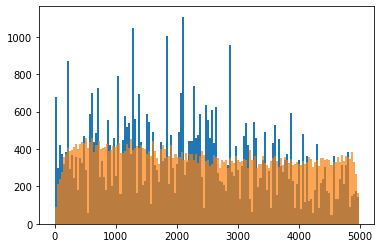

In [ ]:
plt.hist(wire[:compare_N_hits], bins=150);
plt.hist(fake_wire, bins=150, alpha=0.7);

In [ ]:
# /!\ Careful memory hungry!
# Let's do it in N steps
N_steps = 8
fk_wx = np.zeros_like(fake_wire)
fk_wy = np.zeros_like(fake_wire)
for i in range(N_steps):
    start = i * fake_wire.size // N_steps
    end = (i+1) * fake_wire.size // N_steps
    print(start, end)
    fk_wx_step, fk_wy_step = wire_pos(fake_wire[start:end])
    fk_wx[start:end] = fk_wx_step
    fk_wy[start:end] = fk_wy_step
    

print(fk_wx)

0 6725
6725 13450
13450 20175
20175 26900
26900 33625
33625 40350
40350 47075
47075 53800
[ 558  292 -627 ...  165 -561  359]


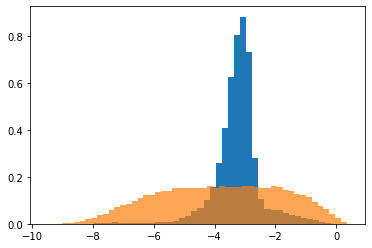

In [ ]:
plt.hist(np.log10(edep), bins=50, density=True);
plt.hist(fake_hits[0], bins=50, alpha=0.7, density=True);

In [ ]:
fk_edep = np.power(10, fake_hits[0])

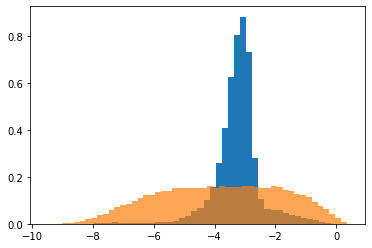

In [ ]:
plt.hist(np.log10(edep), bins=50, density=True);
plt.hist(np.log10(fk_edep), bins=50, alpha=0.7, density=True);

In [ ]:
n_hits_per_bunch = data.size // n_bunches
n_hits_per_bunch

10437.0

NameError: name 'fk_wx' is not defined

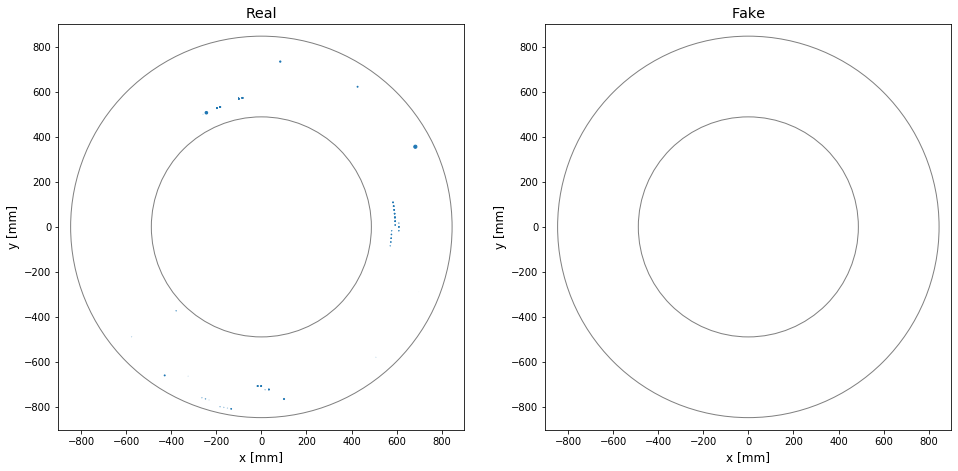

In [ ]:
plt.figure(figsize=(16, 8))

N = compare_N_hits // 10

plt.subplot(121)
ax = plt.gca()
#grid_and_walls(ax)
only_walls(ax)
ax.set_aspect(1)
plt.title('Real')
plt.scatter(wx[:N], wy[:N], s=edep[:N] * 100, cmap='tab10');


plt.subplot(122)
ax = plt.gca()
#grid_and_walls(ax)
only_walls(ax)
ax.set_aspect(1)
plt.title('Fake')
plt.scatter(fk_wx[:N], fk_wy[:N], s=fk_edep[:N] * 100, cmap='tab10');


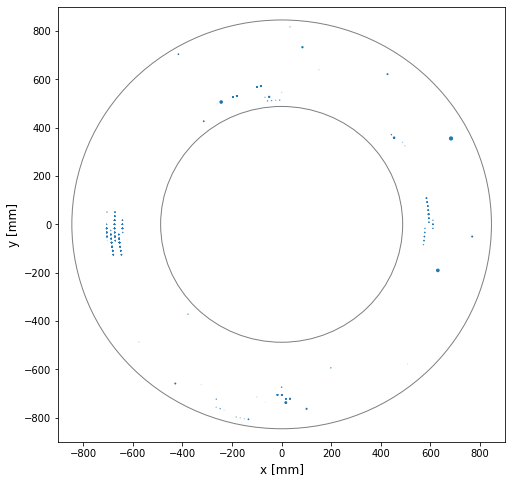

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
#grid_and_walls(ax)
only_walls(ax)

plt.scatter(wx[:N], wy[:N], s=edep[:N] * 100, cmap='tab10');

In [ ]:
for i in range(int(n_bunches+1)):
    print("Hits in bunch %02d:  %d" % (i, event_id[(event_id >= i * 16e6) * (event_id < (i+1) * 16e6)].size))

Hits in bunch 00:  11800
Hits in bunch 01:  9668
Hits in bunch 02:  8952
Hits in bunch 03:  13542
Hits in bunch 04:  13256
Hits in bunch 05:  11393
Hits in bunch 06:  8915
Hits in bunch 07:  9114
Hits in bunch 08:  8755
Hits in bunch 09:  10619
Hits in bunch 10:  9838
Hits in bunch 11:  11383
Hits in bunch 12:  10898
Hits in bunch 13:  8393
Hits in bunch 14:  11094
Hits in bunch 15:  3950


In [ ]:
sample_real(10)

tensor([[ 0.2202,  0.7926, -0.7123],
        [ 0.2980,  0.7926, -0.7119],
        [ 0.3027,  0.7926, -0.7962],
        [ 0.2196,  0.7926, -0.8756],
        [ 0.3102,  0.7926, -0.8760],
        [ 0.3729,  0.7926, -0.7966],
        [ 0.3674,  0.7926, -0.7962],
        [ 0.3334,  0.7926, -0.8756],
        [ 0.3206,  0.7926, -0.8760],
        [ 0.3579,  0.7926, -0.7966]])

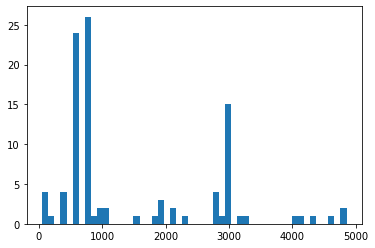

In [ ]:
plt.hist(inv_transform(sample_real(100))[:,2], bins=50);

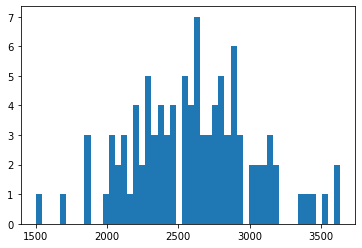

In [ ]:
plt.hist(inv_transform(sample_fake(100))[:,2], bins=50);

# 

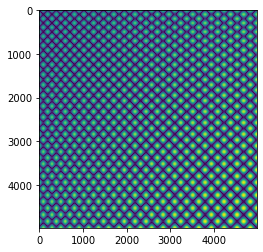

In [ ]:
# Calculate all wire distances and store in a tensor
from scipy.spatial.distance import cdist

distances = cdist(wire_x[:,np.newaxis], wire_x[:,np.newaxis])

plt.imshow(distances)

In [ ]:
_a = torch.tensor([1.5, 2.0, 1.5, 1.5], requires_grad=True)
_b = torch.pairwise_distance(_a.unsqueeze(0).T, _a).mean()

_b.backward()
_a.grad

tensor([-0.3943,  1.1830, -0.3943, -0.3943])